In [1]:
!pip install torch torchvision matplotlib numpy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print(torch.cuda.is_available())

True


In [4]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ttngxiao","key":"22c37e49664d14754fdfd7b63613d739"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip install kaggle
!mkdir -p /content/drive/MyDrive/mini_project2/data
!kaggle datasets download -d zaraks/pascal-voc-2007 -p /content/drive/MyDrive/mini_project2/data
!unzip /content/drive/MyDrive/mini_project2/data/pascal-voc-2007.zip -d /content/drive/MyDrive/mini_project2/data/voc

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001729.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001730.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001732.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001733.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001734.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001738.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/001739.jpg  
  inflating: /content/drive/MyDrive/mini_project2/data/voc/voctrainval_06-nov-2007/VOCdevkit/VOC20

## Load Data

Number of classes: 21
Classes: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Train samples: 209
Validation samples: 213
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


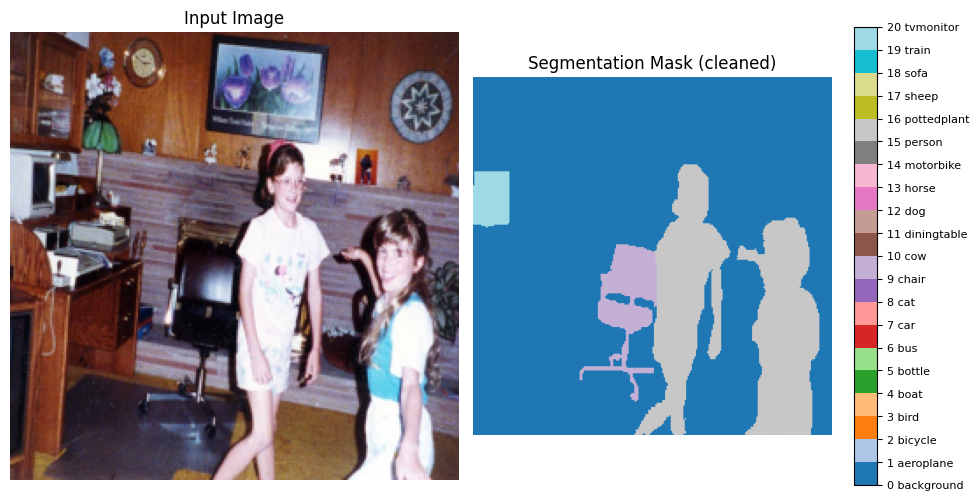

In [3]:
!pip install torchvision matplotlib numpy --quiet

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import InterpolationMode

# --- Enable inline plots ---
%matplotlib inline

# ==============================
# 1. Define the 21 classes
# ==============================
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print("Number of classes:", NUM_CLASSES)
print("Classes:", VOC_CLASSES)

# ==============================
# 2. Define image and mask transforms
# ==============================
transform_img = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),  # resize for speed
    transforms.ToTensor(),  # convert to tensor (C,H,W)
])

transform_target = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),  # resize mask
    transforms.PILToTensor(),  # keep as tensor (H,W)
])

transform_img_512 = transforms.Compose([
    transforms.Resize((512, 512), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

transform_target_512 = transforms.Compose([
    transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

# ==============================
# 3. Load the Pascal VOC 2007 dataset
# ==============================
root = '/content/drive/MyDrive/mini_project2/data/voc/VOCtrainval_06-Nov-2007'  # if saved in Drive

train_dataset = VOCSegmentation(
    root=root,
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

val_dataset = VOCSegmentation(
    root=root,
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)

train_dataset_512 = VOCSegmentation(
    root=root,
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img_512,
    target_transform=transform_target_512
)

val_dataset_512 = VOCSegmentation(
    root=root,
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img_512,
    target_transform=transform_target_512
)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# ==============================
# 4. Create DataLoaders
# ==============================
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=False)

train_loader_512 = DataLoader(train_dataset_512, batch_size=4, shuffle=True, drop_last=True)
val_loader_512   = DataLoader(val_dataset_512,  batch_size=4, shuffle=False, drop_last=False)

# ==============================
# 5. Inspect one batch
# ==============================
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

# ==============================
# 6. Visualize a sample
# ==============================
def show_sample(img, mask):
    img = img.permute(1, 2, 0).numpy()  # convert from (C,H,W) to (H,W,C)
    mask = mask.squeeze().numpy().copy()  # remove channel dimension

    # Clean mask values (>20 → background)
    mask[mask > 20] = 0

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    seg_map = plt.imshow(mask, cmap="tab20", vmin=0, vmax=20)
    plt.title("Segmentation Mask (cleaned)")
    plt.axis("off")

    # Custom colorbar with class names
    cbar = plt.colorbar(seg_map, ticks=range(21))
    tick_labels = [f"{i} {VOC_CLASSES[i]}" for i in range(21)]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()

# Show one sample
show_sample(images[0], masks[0])


## Modeling Training

In [4]:
!pip install segmentation-models-pytorch tqdm torchmetrics transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.9 MB/s eta 0:00:00


In [15]:
import segmentation_models_pytorch as smp

In [5]:
# =========================================================
# Setup for models and training
# =====================================================
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, os, json, time, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from typing import Dict, Tuple
from torchvision import transforms
from transformers import SamModel, SamProcessor
from scipy.ndimage import distance_transform_edt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
project_dir = '/content/drive/MyDrive/mini_project2'
os.makedirs(f'{project_dir}/checkpoints', exist_ok=True)
os.makedirs(f'{project_dir}/results', exist_ok=True)
print("Device:", device)

Device: cuda


In [10]:
# =====================================================
# Metrics
# =====================================================
class SegMetrics:
    def __init__(self, num_classes=21):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        """Reset confusion matrix and HD95 records."""
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        self.hd95_per_class = {c: [] for c in range(self.num_classes)}

    def _update_cm(self, pred, target):
        """Update confusion matrix for IoU, Dice, and accuracy metrics."""
        mask = (target >= 0) & (target < self.num_classes)
        hist = np.bincount(
            self.num_classes * target[mask].astype(int) + pred[mask].astype(int),
            minlength=self.num_classes**2
        ).reshape(self.num_classes, self.num_classes)
        self.confusion_matrix += hist

    def _hd95(self, a, b):
        """
        Compute 95th percentile Hausdorff distance between two binary masks.

        Rules:
        - If the class does not appear in the ground truth (b.sum() == 0) → return NaN (skip it).
        - If GT exists but prediction is empty (a.sum() == 0) → return Inf (penalize).
        - Otherwise compute HD95 normally.
        """
        if b.sum() == 0:
            return np.nan
        if a.sum() == 0:
            return np.inf

        da = distance_transform_edt(1 - a)
        db = distance_transform_edt(1 - b)
        sda = da[b.astype(bool)]
        sdb = db[a.astype(bool)]
        if sda.size == 0 or sdb.size == 0:
            return np.inf
        return float(np.percentile(np.concatenate([sda, sdb]), 95))

    def update(self, logits, target):
        """Accumulate metrics over a batch of predictions."""
        with torch.no_grad():
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            tgt = target.squeeze(1).long().cpu().numpy()

        for p, t in zip(pred, tgt):
            self._update_cm(p, t)
            for c in range(self.num_classes):
                a = (p == c).astype(np.uint8)
                b = (t == c).astype(np.uint8)
                hd = self._hd95(a, b)
                # Record finite values and Inf (skip NaN only)
                if not np.isnan(hd):
                    self.hd95_per_class[c].append(hd)

    def compute(self):
        """Compute overall and per-class segmentation metrics."""
        cm = self.confusion_matrix
        tp = np.diag(cm)
        gt = cm.sum(axis=1)
        pred = cm.sum(axis=0)
        fp = pred - tp
        fn = gt - tp

        with np.errstate(divide="ignore", invalid="ignore"):
            iou = tp / (tp + fp + fn)
            acc = tp / np.maximum(gt, 1e-8)
            dice = (2 * tp) / (2 * tp + fp + fn)

        valid = gt > 0
        overall = {
            "pixel_accuracy": float(tp.sum() / max(1, cm.sum())),
            "mIoU": float(np.nanmean(iou[valid])) if valid.any() else float("nan"),
            "mean_dice": float(np.nanmean(dice[valid])) if valid.any() else float("nan"),
        }

        per_class = {}
        hd_vals = []
        for c in range(self.num_classes):
            # Compute per-class HD95 mean (skip if no records)
            if self.hd95_per_class[c]:
                chd = float(np.nanmean(self.hd95_per_class[c]))
            else:
                chd = np.nan
            if np.isfinite(chd):
                hd_vals.append(chd)
            per_class[c] = {
                "iou": float(iou[c]),
                "accuracy": float(acc[c]),
                "dice": float(dice[c]),
                "hd95": chd,
            }

        overall["mean_hd95"] = float(np.nanmean(hd_vals)) if hd_vals else float("nan")
        return overall, per_class, cm

# =====================================================
# Train / Eval utilities
# =====================================================

def train_one_epoch(model, loader, optimizer, forward_fn):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device).squeeze(1).long()
        optimizer.zero_grad()
        outputs = forward_fn(model, imgs)
        criterion = nn.CrossEntropyLoss(ignore_index=255)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, forward_fn):
    model.eval()
    m = SegMetrics(num_classes=21); m.reset()
    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = forward_fn(model, imgs)
        m.update(outputs, masks)
    overall, per_class, cm = m.compute()
    return overall, per_class, cm

def save_results(name, overall, per_class, cm, history):
    np.save(f"{project_dir}/results/{name}_cm.npy", cm)
    with open(f"{project_dir}/results/{name}_metrics.json", "w") as f:
        json.dump({"overall": overall, "per_class": per_class}, f, indent=2)
    pd.DataFrame(history).to_csv(f"{project_dir}/results/{name}_history.csv", index=False)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm / np.maximum(1, cm.sum(axis=1, keepdims=True)), cmap="Blues")
    plt.title(f"{name} Confusion Matrix (Normalized)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{project_dir}/results/{name}_cm.png", dpi=300)
    plt.close()

In [17]:
forward_fn = lambda model, x: model(x)

## Train and Save Results

In [7]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [19]:
# =====================================================
# U-Net (Resnet18)
# =====================================================
import segmentation_models_pytorch as smp
unet_18 = smp.Unet(encoder_name="resnet18", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(unet_18.parameters(), lr=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 100
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch(unet_18, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_18, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net-18] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_18.state_dict(), f"{project_dir}/checkpoints/unet_18_best.pth")
        save_results("unet_18", overall, per_class, cm, history)

[U-Net-18] Epoch 1/100 | Loss=2.5902 | mIoU=0.0584


[U-Net-18] Epoch 2/100 | Loss=1.9267 | mIoU=0.0775


[U-Net-18] Epoch 3/100 | Loss=1.5143 | mIoU=0.0942


[U-Net-18] Epoch 4/100 | Loss=1.2917 | mIoU=0.0978


[U-Net-18] Epoch 5/100 | Loss=1.1307 | mIoU=0.1053


[U-Net-18] Epoch 6/100 | Loss=0.9829 | mIoU=0.1200


[U-Net-18] Epoch 7/100 | Loss=0.9265 | mIoU=0.1075


[U-Net-18] Epoch 8/100 | Loss=0.9016 | mIoU=0.1119


[U-Net-18] Epoch 9/100 | Loss=0.7903 | mIoU=0.1183


[U-Net-18] Epoch 10/100 | Loss=0.7786 | mIoU=0.1215


[U-Net-18] Epoch 11/100 | Loss=0.7529 | mIoU=0.1210


[U-Net-18] Epoch 12/100 | Loss=0.7164 | mIoU=0.1289


[U-Net-18] Epoch 13/100 | Loss=0.6677 | mIoU=0.1235


[U-Net-18] Epoch 14/100 | Loss=0.6821 | mIoU=0.1270


[U-Net-18] Epoch 15/100 | Loss=0.6299 | mIoU=0.1308


[U-Net-18] Epoch 16/100 | Loss=0.6266 | mIoU=0.1489


[U-Net-18] Epoch 17/100 | Loss=0.6093 | mIoU=0.1313


[U-Net-18] Epoch 18/100 | Loss=0.5840 | mIoU=0.1540


[U-Net-18] Epoch 19/100 | Loss=0.6521 | mIoU=0.1625


[U-Net-18] Epoch 20/100 | Loss=0.5672 | mIoU=0.1499


[U-Net-18] Epoch 21/100 | Loss=0.5285 | mIoU=0.1582


[U-Net-18] Epoch 22/100 | Loss=0.5317 | mIoU=0.1611


[U-Net-18] Epoch 23/100 | Loss=0.5003 | mIoU=0.1545


[U-Net-18] Epoch 24/100 | Loss=0.4812 | mIoU=0.1684


[U-Net-18] Epoch 25/100 | Loss=0.4692 | mIoU=0.1693


[U-Net-18] Epoch 26/100 | Loss=0.4447 | mIoU=0.1759


[U-Net-18] Epoch 27/100 | Loss=0.4240 | mIoU=0.1796


[U-Net-18] Epoch 28/100 | Loss=0.4260 | mIoU=0.1896


[U-Net-18] Epoch 29/100 | Loss=0.4002 | mIoU=0.1872


[U-Net-18] Epoch 30/100 | Loss=0.3948 | mIoU=0.1810


[U-Net-18] Epoch 31/100 | Loss=0.3789 | mIoU=0.2069


[U-Net-18] Epoch 32/100 | Loss=0.3684 | mIoU=0.2142


[U-Net-18] Epoch 33/100 | Loss=0.3784 | mIoU=0.1979


[U-Net-18] Epoch 34/100 | Loss=0.3602 | mIoU=0.1904


[U-Net-18] Epoch 35/100 | Loss=0.3388 | mIoU=0.2041


[U-Net-18] Epoch 36/100 | Loss=0.3222 | mIoU=0.2247


[U-Net-18] Epoch 37/100 | Loss=0.3202 | mIoU=0.2412


[U-Net-18] Epoch 38/100 | Loss=0.3030 | mIoU=0.2067


[U-Net-18] Epoch 39/100 | Loss=0.2931 | mIoU=0.2405


[U-Net-18] Epoch 40/100 | Loss=0.2877 | mIoU=0.2346


[U-Net-18] Epoch 41/100 | Loss=0.2871 | mIoU=0.2231


[U-Net-18] Epoch 42/100 | Loss=0.3493 | mIoU=0.2118


[U-Net-18] Epoch 43/100 | Loss=0.3318 | mIoU=0.2303


[U-Net-18] Epoch 44/100 | Loss=0.2889 | mIoU=0.2392


[U-Net-18] Epoch 45/100 | Loss=0.2515 | mIoU=0.2434


[U-Net-18] Epoch 46/100 | Loss=0.2333 | mIoU=0.2427


[U-Net-18] Epoch 47/100 | Loss=0.2373 | mIoU=0.2342


[U-Net-18] Epoch 48/100 | Loss=0.2286 | mIoU=0.2508


[U-Net-18] Epoch 49/100 | Loss=0.2204 | mIoU=0.2494


[U-Net-18] Epoch 50/100 | Loss=0.2326 | mIoU=0.2209


[U-Net-18] Epoch 51/100 | Loss=0.2261 | mIoU=0.2259


[U-Net-18] Epoch 52/100 | Loss=0.2517 | mIoU=0.1942


[U-Net-18] Epoch 53/100 | Loss=0.2464 | mIoU=0.2203


[U-Net-18] Epoch 54/100 | Loss=0.2309 | mIoU=0.2179


[U-Net-18] Epoch 55/100 | Loss=0.1993 | mIoU=0.2441


[U-Net-18] Epoch 56/100 | Loss=0.1763 | mIoU=0.2458


[U-Net-18] Epoch 57/100 | Loss=0.1617 | mIoU=0.2548


[U-Net-18] Epoch 58/100 | Loss=0.1593 | mIoU=0.2500


[U-Net-18] Epoch 59/100 | Loss=0.2377 | mIoU=0.2499


[U-Net-18] Epoch 60/100 | Loss=0.2421 | mIoU=0.2226


[U-Net-18] Epoch 61/100 | Loss=0.2156 | mIoU=0.2397


[U-Net-18] Epoch 62/100 | Loss=0.2092 | mIoU=0.2589


[U-Net-18] Epoch 63/100 | Loss=0.1736 | mIoU=0.2544


[U-Net-18] Epoch 64/100 | Loss=0.1566 | mIoU=0.2731


[U-Net-18] Epoch 65/100 | Loss=0.1337 | mIoU=0.2981


[U-Net-18] Epoch 66/100 | Loss=0.1263 | mIoU=0.2927


[U-Net-18] Epoch 67/100 | Loss=0.1433 | mIoU=0.2687


[U-Net-18] Epoch 68/100 | Loss=0.1565 | mIoU=0.2412


[U-Net-18] Epoch 69/100 | Loss=0.1775 | mIoU=0.2416


[U-Net-18] Epoch 70/100 | Loss=0.1948 | mIoU=0.2604


[U-Net-18] Epoch 71/100 | Loss=0.1495 | mIoU=0.2560


[U-Net-18] Epoch 72/100 | Loss=0.1175 | mIoU=0.2509


[U-Net-18] Epoch 73/100 | Loss=0.1033 | mIoU=0.2609


[U-Net-18] Epoch 74/100 | Loss=0.1030 | mIoU=0.2609


[U-Net-18] Epoch 75/100 | Loss=0.1081 | mIoU=0.2518


[U-Net-18] Epoch 76/100 | Loss=0.0997 | mIoU=0.2590


[U-Net-18] Epoch 77/100 | Loss=0.0935 | mIoU=0.2422


[U-Net-18] Epoch 78/100 | Loss=0.0922 | mIoU=0.2590


[U-Net-18] Epoch 79/100 | Loss=0.0813 | mIoU=0.2743


[U-Net-18] Epoch 80/100 | Loss=0.0868 | mIoU=0.2714


[U-Net-18] Epoch 81/100 | Loss=0.0724 | mIoU=0.2743


[U-Net-18] Epoch 82/100 | Loss=0.0847 | mIoU=0.2549


[U-Net-18] Epoch 83/100 | Loss=0.0929 | mIoU=0.2675


[U-Net-18] Epoch 84/100 | Loss=0.0946 | mIoU=0.2590


[U-Net-18] Epoch 85/100 | Loss=0.1051 | mIoU=0.2474


[U-Net-18] Epoch 86/100 | Loss=0.0911 | mIoU=0.2616


[U-Net-18] Epoch 87/100 | Loss=0.0803 | mIoU=0.2594


[U-Net-18] Epoch 88/100 | Loss=0.0731 | mIoU=0.2575


[U-Net-18] Epoch 89/100 | Loss=0.0779 | mIoU=0.2796


[U-Net-18] Epoch 90/100 | Loss=0.0716 | mIoU=0.2790


[U-Net-18] Epoch 91/100 | Loss=0.0642 | mIoU=0.2673


[U-Net-18] Epoch 92/100 | Loss=0.0623 | mIoU=0.2668


[U-Net-18] Epoch 93/100 | Loss=0.0526 | mIoU=0.2707


[U-Net-18] Epoch 94/100 | Loss=0.0544 | mIoU=0.2648


[U-Net-18] Epoch 95/100 | Loss=0.0649 | mIoU=0.2568


[U-Net-18] Epoch 96/100 | Loss=0.0632 | mIoU=0.2678


[U-Net-18] Epoch 97/100 | Loss=0.0835 | mIoU=0.2286


[U-Net-18] Epoch 98/100 | Loss=0.1331 | mIoU=0.2280


[U-Net-18] Epoch 99/100 | Loss=0.0914 | mIoU=0.2233


[U-Net-18] Epoch 100/100 | Loss=0.0955 | mIoU=0.2364


In [11]:
# =====================================================
# U-Net （Resnet18 + AdamW）
# =====================================================
import segmentation_models_pytorch as smp
unet_18_adamw = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_18_adamw.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 40
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch(unet_18_adamw, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_18_adamw, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_18_adamw.state_dict(), f"{project_dir}/checkpoints/unet_18_adamw_best.pth")
        save_results("unet_18_adamw", overall, per_class, cm, history)


[U-Net] Epoch 1/40 | Loss=2.9868 | mIoU=0.0483


[U-Net] Epoch 2/40 | Loss=2.4147 | mIoU=0.0695


[U-Net] Epoch 3/40 | Loss=1.9597 | mIoU=0.0793


[U-Net] Epoch 4/40 | Loss=1.6131 | mIoU=0.0671


[U-Net] Epoch 5/40 | Loss=1.3546 | mIoU=0.0830


[U-Net] Epoch 6/40 | Loss=1.1566 | mIoU=0.0747


[U-Net] Epoch 7/40 | Loss=1.0208 | mIoU=0.0736


[U-Net] Epoch 8/40 | Loss=0.9467 | mIoU=0.0665


[U-Net] Epoch 9/40 | Loss=0.8931 | mIoU=0.0694


[U-Net] Epoch 10/40 | Loss=0.8528 | mIoU=0.0673


[U-Net] Epoch 11/40 | Loss=0.7888 | mIoU=0.0697


[U-Net] Epoch 12/40 | Loss=0.7702 | mIoU=0.0696


[U-Net] Epoch 13/40 | Loss=0.7455 | mIoU=0.0725


[U-Net] Epoch 14/40 | Loss=0.7034 | mIoU=0.0831


[U-Net] Epoch 15/40 | Loss=0.6746 | mIoU=0.0832


[U-Net] Epoch 16/40 | Loss=0.6405 | mIoU=0.0869


[U-Net] Epoch 17/40 | Loss=0.6552 | mIoU=0.0910


[U-Net] Epoch 18/40 | Loss=0.6165 | mIoU=0.0895


[U-Net] Epoch 19/40 | Loss=0.5930 | mIoU=0.0967


[U-Net] Epoch 20/40 | Loss=0.5892 | mIoU=0.0978


[U-Net] Epoch 21/40 | Loss=0.6103 | mIoU=0.1014


[U-Net] Epoch 22/40 | Loss=0.6016 | mIoU=0.1098


[U-Net] Epoch 23/40 | Loss=0.5716 | mIoU=0.1085


[U-Net] Epoch 24/40 | Loss=0.5482 | mIoU=0.1126


[U-Net] Epoch 25/40 | Loss=0.5442 | mIoU=0.1208


[U-Net] Epoch 26/40 | Loss=0.5137 | mIoU=0.1182


[U-Net] Epoch 27/40 | Loss=0.5067 | mIoU=0.1262


[U-Net] Epoch 28/40 | Loss=0.4974 | mIoU=0.1218


[U-Net] Epoch 29/40 | Loss=0.4792 | mIoU=0.1187


[U-Net] Epoch 30/40 | Loss=0.4680 | mIoU=0.1296


[U-Net] Epoch 31/40 | Loss=0.4764 | mIoU=0.1261


[U-Net] Epoch 32/40 | Loss=0.4726 | mIoU=0.1194


[U-Net] Epoch 33/40 | Loss=0.4783 | mIoU=0.1263


[U-Net] Epoch 34/40 | Loss=0.4680 | mIoU=0.1259


[U-Net] Epoch 35/40 | Loss=0.4540 | mIoU=0.1354


[U-Net] Epoch 36/40 | Loss=0.4346 | mIoU=0.1325


[U-Net] Epoch 37/40 | Loss=0.4175 | mIoU=0.1296


[U-Net] Epoch 38/40 | Loss=0.4095 | mIoU=0.1374


[U-Net] Epoch 39/40 | Loss=0.4050 | mIoU=0.1388


[U-Net] Epoch 40/40 | Loss=0.4168 | mIoU=0.1223


In [20]:
# =====================================================
# U-Net （ResNet34 + Adam）
# =====================================================
import segmentation_models_pytorch as smp

unet_resnet34 = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21
).to(device)

optimizer = torch.optim.Adam(unet_resnet34.parameters(), lr=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 100
best_miou = 0
history = []

for ep in range(epochs):
    loss = train_one_epoch(unet_resnet34, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_resnet34, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net-ResNet34] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(unet_resnet34.state_dict(), f"{project_dir}/checkpoints/unet_34_best.pth")
        save_results("unet_34", overall, per_class, cm, history)


[U-Net-ResNet34] Epoch 1/100 | Loss=2.9012 | mIoU=0.0431


[U-Net-ResNet34] Epoch 2/100 | Loss=2.2688 | mIoU=0.0651


[U-Net-ResNet34] Epoch 3/100 | Loss=1.7902 | mIoU=0.0820


[U-Net-ResNet34] Epoch 4/100 | Loss=1.4535 | mIoU=0.0969


[U-Net-ResNet34] Epoch 5/100 | Loss=1.2519 | mIoU=0.0861


[U-Net-ResNet34] Epoch 6/100 | Loss=1.0794 | mIoU=0.1052


[U-Net-ResNet34] Epoch 7/100 | Loss=0.9853 | mIoU=0.1033


[U-Net-ResNet34] Epoch 8/100 | Loss=0.9095 | mIoU=0.1035


[U-Net-ResNet34] Epoch 9/100 | Loss=0.8280 | mIoU=0.1216


[U-Net-ResNet34] Epoch 10/100 | Loss=0.7673 | mIoU=0.1295


[U-Net-ResNet34] Epoch 11/100 | Loss=0.7444 | mIoU=0.1300


[U-Net-ResNet34] Epoch 12/100 | Loss=0.7482 | mIoU=0.1330


[U-Net-ResNet34] Epoch 13/100 | Loss=0.7115 | mIoU=0.1201


[U-Net-ResNet34] Epoch 14/100 | Loss=0.6719 | mIoU=0.1285


[U-Net-ResNet34] Epoch 15/100 | Loss=0.6554 | mIoU=0.1231


[U-Net-ResNet34] Epoch 16/100 | Loss=0.6273 | mIoU=0.1339


[U-Net-ResNet34] Epoch 17/100 | Loss=0.5920 | mIoU=0.1259


[U-Net-ResNet34] Epoch 18/100 | Loss=0.5678 | mIoU=0.1344


[U-Net-ResNet34] Epoch 19/100 | Loss=0.5591 | mIoU=0.1320


[U-Net-ResNet34] Epoch 20/100 | Loss=0.5943 | mIoU=0.1237


[U-Net-ResNet34] Epoch 21/100 | Loss=0.5538 | mIoU=0.1383


[U-Net-ResNet34] Epoch 22/100 | Loss=0.5448 | mIoU=0.1368


[U-Net-ResNet34] Epoch 23/100 | Loss=0.5635 | mIoU=0.1422


[U-Net-ResNet34] Epoch 24/100 | Loss=0.6151 | mIoU=0.1520


[U-Net-ResNet34] Epoch 25/100 | Loss=0.5059 | mIoU=0.1455


[U-Net-ResNet34] Epoch 26/100 | Loss=0.4862 | mIoU=0.1657


[U-Net-ResNet34] Epoch 27/100 | Loss=0.4895 | mIoU=0.1826


[U-Net-ResNet34] Epoch 28/100 | Loss=0.4622 | mIoU=0.1768


[U-Net-ResNet34] Epoch 29/100 | Loss=0.4774 | mIoU=0.1713


[U-Net-ResNet34] Epoch 30/100 | Loss=0.4518 | mIoU=0.1736


[U-Net-ResNet34] Epoch 31/100 | Loss=0.4777 | mIoU=0.1696


[U-Net-ResNet34] Epoch 32/100 | Loss=0.4321 | mIoU=0.1655


[U-Net-ResNet34] Epoch 33/100 | Loss=0.4170 | mIoU=0.1889


[U-Net-ResNet34] Epoch 34/100 | Loss=0.3896 | mIoU=0.1781


[U-Net-ResNet34] Epoch 35/100 | Loss=0.3780 | mIoU=0.1881


[U-Net-ResNet34] Epoch 36/100 | Loss=0.3799 | mIoU=0.1802


[U-Net-ResNet34] Epoch 37/100 | Loss=0.3652 | mIoU=0.1889


[U-Net-ResNet34] Epoch 38/100 | Loss=0.3809 | mIoU=0.1743


[U-Net-ResNet34] Epoch 39/100 | Loss=0.4070 | mIoU=0.1547


[U-Net-ResNet34] Epoch 40/100 | Loss=0.4123 | mIoU=0.1856


[U-Net-ResNet34] Epoch 41/100 | Loss=0.3984 | mIoU=0.2006


[U-Net-ResNet34] Epoch 42/100 | Loss=0.3519 | mIoU=0.1850


[U-Net-ResNet34] Epoch 43/100 | Loss=0.3477 | mIoU=0.1735


[U-Net-ResNet34] Epoch 44/100 | Loss=0.3579 | mIoU=0.2018


[U-Net-ResNet34] Epoch 45/100 | Loss=0.3462 | mIoU=0.2222


[U-Net-ResNet34] Epoch 46/100 | Loss=0.3291 | mIoU=0.2404


[U-Net-ResNet34] Epoch 47/100 | Loss=0.3344 | mIoU=0.2366


[U-Net-ResNet34] Epoch 48/100 | Loss=0.2873 | mIoU=0.2562


[U-Net-ResNet34] Epoch 49/100 | Loss=0.2989 | mIoU=0.2260


[U-Net-ResNet34] Epoch 50/100 | Loss=0.2938 | mIoU=0.2135


[U-Net-ResNet34] Epoch 51/100 | Loss=0.3103 | mIoU=0.2209


[U-Net-ResNet34] Epoch 52/100 | Loss=0.2942 | mIoU=0.2342


[U-Net-ResNet34] Epoch 53/100 | Loss=0.2810 | mIoU=0.2500


[U-Net-ResNet34] Epoch 54/100 | Loss=0.2669 | mIoU=0.2528


[U-Net-ResNet34] Epoch 55/100 | Loss=0.2588 | mIoU=0.2411


[U-Net-ResNet34] Epoch 56/100 | Loss=0.2425 | mIoU=0.2461


[U-Net-ResNet34] Epoch 57/100 | Loss=0.2617 | mIoU=0.2496


[U-Net-ResNet34] Epoch 58/100 | Loss=0.2550 | mIoU=0.2332


[U-Net-ResNet34] Epoch 59/100 | Loss=0.2673 | mIoU=0.2550


[U-Net-ResNet34] Epoch 60/100 | Loss=0.2934 | mIoU=0.2386


[U-Net-ResNet34] Epoch 61/100 | Loss=0.2635 | mIoU=0.2643


[U-Net-ResNet34] Epoch 62/100 | Loss=0.2343 | mIoU=0.2293


[U-Net-ResNet34] Epoch 63/100 | Loss=0.2178 | mIoU=0.2698


[U-Net-ResNet34] Epoch 64/100 | Loss=0.2405 | mIoU=0.2608


[U-Net-ResNet34] Epoch 65/100 | Loss=0.2684 | mIoU=0.2438


[U-Net-ResNet34] Epoch 66/100 | Loss=0.2170 | mIoU=0.2616


[U-Net-ResNet34] Epoch 67/100 | Loss=0.2072 | mIoU=0.2528


[U-Net-ResNet34] Epoch 68/100 | Loss=0.1909 | mIoU=0.2768


[U-Net-ResNet34] Epoch 69/100 | Loss=0.1924 | mIoU=0.2611


[U-Net-ResNet34] Epoch 70/100 | Loss=0.1863 | mIoU=0.2690


[U-Net-ResNet34] Epoch 71/100 | Loss=0.1876 | mIoU=0.2732


[U-Net-ResNet34] Epoch 72/100 | Loss=0.1747 | mIoU=0.2564


[U-Net-ResNet34] Epoch 73/100 | Loss=0.1667 | mIoU=0.2700


[U-Net-ResNet34] Epoch 74/100 | Loss=0.1922 | mIoU=0.2363


[U-Net-ResNet34] Epoch 75/100 | Loss=0.1718 | mIoU=0.2586


[U-Net-ResNet34] Epoch 76/100 | Loss=0.1615 | mIoU=0.2414


[U-Net-ResNet34] Epoch 77/100 | Loss=0.1472 | mIoU=0.2774


[U-Net-ResNet34] Epoch 78/100 | Loss=0.1399 | mIoU=0.2792


[U-Net-ResNet34] Epoch 79/100 | Loss=0.1508 | mIoU=0.2676


[U-Net-ResNet34] Epoch 80/100 | Loss=0.2617 | mIoU=0.2744


[U-Net-ResNet34] Epoch 81/100 | Loss=0.1699 | mIoU=0.2709


[U-Net-ResNet34] Epoch 82/100 | Loss=0.1564 | mIoU=0.2521


[U-Net-ResNet34] Epoch 83/100 | Loss=0.1371 | mIoU=0.2833


[U-Net-ResNet34] Epoch 84/100 | Loss=0.1392 | mIoU=0.2806


[U-Net-ResNet34] Epoch 85/100 | Loss=0.1494 | mIoU=0.2681


[U-Net-ResNet34] Epoch 86/100 | Loss=0.1320 | mIoU=0.2744


[U-Net-ResNet34] Epoch 87/100 | Loss=0.1481 | mIoU=0.2594


[U-Net-ResNet34] Epoch 88/100 | Loss=0.1660 | mIoU=0.2482


[U-Net-ResNet34] Epoch 89/100 | Loss=0.1301 | mIoU=0.2721


[U-Net-ResNet34] Epoch 90/100 | Loss=0.1213 | mIoU=0.2689


[U-Net-ResNet34] Epoch 91/100 | Loss=0.1441 | mIoU=0.2815


[U-Net-ResNet34] Epoch 92/100 | Loss=0.1367 | mIoU=0.2591


[U-Net-ResNet34] Epoch 93/100 | Loss=0.1384 | mIoU=0.2674


[U-Net-ResNet34] Epoch 94/100 | Loss=0.1299 | mIoU=0.2645


[U-Net-ResNet34] Epoch 95/100 | Loss=0.1521 | mIoU=0.2537


[U-Net-ResNet34] Epoch 96/100 | Loss=0.1458 | mIoU=0.2291


[U-Net-ResNet34] Epoch 97/100 | Loss=0.1143 | mIoU=0.2605


[U-Net-ResNet34] Epoch 98/100 | Loss=0.1056 | mIoU=0.2650


[U-Net-ResNet34] Epoch 99/100 | Loss=0.0888 | mIoU=0.2688


[U-Net-ResNet34] Epoch 100/100 | Loss=0.1762 | mIoU=0.2517


In [25]:
# =====================================================
# U-Net （Resnet34 + AdamW）
# =====================================================
import segmentation_models_pytorch as smp
unet_34_adamw = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_34_adamw.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 100
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch(unet_34_adamw, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_34_adamw, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_34_adamw.state_dict(), f"{project_dir}/checkpoints/unet_34_adamw_best.pth")
        save_results("unet_34_adamw", overall, per_class, cm, history)

[U-Net] Epoch 1/100 | Loss=2.7182 | mIoU=0.0642


[U-Net] Epoch 2/100 | Loss=2.0786 | mIoU=0.1052


[U-Net] Epoch 3/100 | Loss=1.7005 | mIoU=0.1056


[U-Net] Epoch 4/100 | Loss=1.3948 | mIoU=0.0992


[U-Net] Epoch 5/100 | Loss=1.1942 | mIoU=0.0961


[U-Net] Epoch 6/100 | Loss=1.0700 | mIoU=0.1099


[U-Net] Epoch 7/100 | Loss=0.9504 | mIoU=0.0959


[U-Net] Epoch 8/100 | Loss=0.8790 | mIoU=0.1081


[U-Net] Epoch 9/100 | Loss=0.8338 | mIoU=0.1047


[U-Net] Epoch 10/100 | Loss=0.7880 | mIoU=0.1200


[U-Net] Epoch 11/100 | Loss=0.7601 | mIoU=0.1149


[U-Net] Epoch 12/100 | Loss=0.7278 | mIoU=0.1217


[U-Net] Epoch 13/100 | Loss=0.7043 | mIoU=0.1255


[U-Net] Epoch 14/100 | Loss=0.7180 | mIoU=0.1357


[U-Net] Epoch 15/100 | Loss=0.6773 | mIoU=0.1251


[U-Net] Epoch 16/100 | Loss=0.6473 | mIoU=0.1308


[U-Net] Epoch 17/100 | Loss=0.5987 | mIoU=0.1474


[U-Net] Epoch 18/100 | Loss=0.5824 | mIoU=0.1569


[U-Net] Epoch 19/100 | Loss=0.5780 | mIoU=0.1547


[U-Net] Epoch 20/100 | Loss=0.5254 | mIoU=0.1710


[U-Net] Epoch 21/100 | Loss=0.5294 | mIoU=0.1606


[U-Net] Epoch 22/100 | Loss=0.5046 | mIoU=0.1729


[U-Net] Epoch 23/100 | Loss=0.4907 | mIoU=0.1875


[U-Net] Epoch 24/100 | Loss=0.4899 | mIoU=0.1876


[U-Net] Epoch 25/100 | Loss=0.4725 | mIoU=0.2019


[U-Net] Epoch 26/100 | Loss=0.4876 | mIoU=0.1786


[U-Net] Epoch 27/100 | Loss=0.4774 | mIoU=0.1668


[U-Net] Epoch 28/100 | Loss=0.4601 | mIoU=0.1970


[U-Net] Epoch 29/100 | Loss=0.4244 | mIoU=0.2144


[U-Net] Epoch 30/100 | Loss=0.4164 | mIoU=0.2062


[U-Net] Epoch 31/100 | Loss=0.4034 | mIoU=0.2291


[U-Net] Epoch 32/100 | Loss=0.3743 | mIoU=0.2392


[U-Net] Epoch 33/100 | Loss=0.3636 | mIoU=0.2407


[U-Net] Epoch 34/100 | Loss=0.3503 | mIoU=0.2479


[U-Net] Epoch 35/100 | Loss=0.3525 | mIoU=0.2484


[U-Net] Epoch 36/100 | Loss=0.3394 | mIoU=0.2577


[U-Net] Epoch 37/100 | Loss=0.3320 | mIoU=0.2436


[U-Net] Epoch 38/100 | Loss=0.3305 | mIoU=0.2218


[U-Net] Epoch 39/100 | Loss=0.3705 | mIoU=0.2059


[U-Net] Epoch 40/100 | Loss=0.3432 | mIoU=0.2236


[U-Net] Epoch 41/100 | Loss=0.3174 | mIoU=0.2405


[U-Net] Epoch 42/100 | Loss=0.2975 | mIoU=0.2557


[U-Net] Epoch 43/100 | Loss=0.2738 | mIoU=0.2542


[U-Net] Epoch 44/100 | Loss=0.2661 | mIoU=0.2677


[U-Net] Epoch 45/100 | Loss=0.2457 | mIoU=0.2776


[U-Net] Epoch 46/100 | Loss=0.2344 | mIoU=0.2661


[U-Net] Epoch 47/100 | Loss=0.2159 | mIoU=0.2697


[U-Net] Epoch 48/100 | Loss=0.2005 | mIoU=0.2740


[U-Net] Epoch 49/100 | Loss=0.2062 | mIoU=0.2778


[U-Net] Epoch 50/100 | Loss=0.1983 | mIoU=0.2702


[U-Net] Epoch 51/100 | Loss=0.1878 | mIoU=0.2588


[U-Net] Epoch 52/100 | Loss=0.1845 | mIoU=0.2713


[U-Net] Epoch 53/100 | Loss=0.1934 | mIoU=0.2823


[U-Net] Epoch 54/100 | Loss=0.1924 | mIoU=0.2647


[U-Net] Epoch 55/100 | Loss=0.1730 | mIoU=0.2723


[U-Net] Epoch 56/100 | Loss=0.1825 | mIoU=0.2476


[U-Net] Epoch 57/100 | Loss=0.1591 | mIoU=0.2527


[U-Net] Epoch 58/100 | Loss=0.1630 | mIoU=0.2917


[U-Net] Epoch 59/100 | Loss=0.1588 | mIoU=0.2566


[U-Net] Epoch 60/100 | Loss=0.1697 | mIoU=0.2581


[U-Net] Epoch 61/100 | Loss=0.1528 | mIoU=0.2633


[U-Net] Epoch 62/100 | Loss=0.1436 | mIoU=0.2775


[U-Net] Epoch 63/100 | Loss=0.1615 | mIoU=0.2639


[U-Net] Epoch 64/100 | Loss=0.2079 | mIoU=0.2444


[U-Net] Epoch 65/100 | Loss=0.1784 | mIoU=0.2505


[U-Net] Epoch 66/100 | Loss=0.1543 | mIoU=0.2738


[U-Net] Epoch 67/100 | Loss=0.1510 | mIoU=0.2785


[U-Net] Epoch 68/100 | Loss=0.1345 | mIoU=0.3042


[U-Net] Epoch 69/100 | Loss=0.1245 | mIoU=0.2720


[U-Net] Epoch 70/100 | Loss=0.1194 | mIoU=0.2831


[U-Net] Epoch 71/100 | Loss=0.1560 | mIoU=0.2282


[U-Net] Epoch 72/100 | Loss=0.1646 | mIoU=0.2752


[U-Net] Epoch 73/100 | Loss=0.1769 | mIoU=0.2210


[U-Net] Epoch 74/100 | Loss=0.2862 | mIoU=0.1934


[U-Net] Epoch 75/100 | Loss=0.2173 | mIoU=0.2740


[U-Net] Epoch 76/100 | Loss=0.1544 | mIoU=0.2871


[U-Net] Epoch 77/100 | Loss=0.1156 | mIoU=0.2886


[U-Net] Epoch 78/100 | Loss=0.1020 | mIoU=0.2943


[U-Net] Epoch 79/100 | Loss=0.1322 | mIoU=0.2580


[U-Net] Epoch 80/100 | Loss=0.2287 | mIoU=0.2484


[U-Net] Epoch 81/100 | Loss=0.1611 | mIoU=0.2446


[U-Net] Epoch 82/100 | Loss=0.1242 | mIoU=0.2755


[U-Net] Epoch 83/100 | Loss=0.0996 | mIoU=0.2711


[U-Net] Epoch 84/100 | Loss=0.0833 | mIoU=0.2811


[U-Net] Epoch 85/100 | Loss=0.0832 | mIoU=0.2920


[U-Net] Epoch 86/100 | Loss=0.0774 | mIoU=0.2769


[U-Net] Epoch 87/100 | Loss=0.0723 | mIoU=0.3016


[U-Net] Epoch 88/100 | Loss=0.0971 | mIoU=0.2819


[U-Net] Epoch 89/100 | Loss=0.1043 | mIoU=0.2706


[U-Net] Epoch 90/100 | Loss=0.0830 | mIoU=0.2882


[U-Net] Epoch 91/100 | Loss=0.0779 | mIoU=0.2843


[U-Net] Epoch 92/100 | Loss=0.0859 | mIoU=0.2952


[U-Net] Epoch 93/100 | Loss=0.1603 | mIoU=0.2599


[U-Net] Epoch 94/100 | Loss=0.1519 | mIoU=0.2688


[U-Net] Epoch 95/100 | Loss=0.0970 | mIoU=0.2699


[U-Net] Epoch 96/100 | Loss=0.0730 | mIoU=0.2740


[U-Net] Epoch 97/100 | Loss=0.0736 | mIoU=0.2617


[U-Net] Epoch 98/100 | Loss=0.0655 | mIoU=0.2695


[U-Net] Epoch 99/100 | Loss=0.0666 | mIoU=0.2748


[U-Net] Epoch 100/100 | Loss=0.0785 | mIoU=0.2557


In [16]:
# =====================================================
# U-Net （ResNet34 + AdamW + CosineLR）
# =====================================================
unet_34_adamw_cosine = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21
).to(device)

optimizer = torch.optim.AdamW(unet_34_adamw_cosine.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

forward_fn = lambda model, x: model(x)
epochs = 100
best_miou = 0
history = []

for ep in range(epochs):
    loss = train_one_epoch(unet_34_adamw_cosine, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_34_adamw_cosine, val_loader, forward_fn)
    scheduler.step()
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, "lr": scheduler.get_last_lr()[0], **overall})
    print(f"[U-Net-34-AdamW-CosineLR] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(unet_34_adamw_cosine.state_dict(), f"{project_dir}/checkpoints/unet_34_adamw_cosine_best.pth")
        save_results("unet_34_adamw_cosine", overall, per_class, cm, history)


[U-Net-34-AdamW-CosineLR] Epoch 1/100 | Loss=2.8259 | mIoU=0.0666 | LR=0.000100


[U-Net-34-AdamW-CosineLR] Epoch 2/100 | Loss=2.2264 | mIoU=0.1042 | LR=0.000100


[U-Net-34-AdamW-CosineLR] Epoch 3/100 | Loss=1.7430 | mIoU=0.1185 | LR=0.000100


[U-Net-34-AdamW-CosineLR] Epoch 4/100 | Loss=1.4276 | mIoU=0.1153 | LR=0.000100


[U-Net-34-AdamW-CosineLR] Epoch 5/100 | Loss=1.1907 | mIoU=0.1169 | LR=0.000099


[U-Net-34-AdamW-CosineLR] Epoch 6/100 | Loss=1.0323 | mIoU=0.1104 | LR=0.000099


[U-Net-34-AdamW-CosineLR] Epoch 7/100 | Loss=0.9316 | mIoU=0.1113 | LR=0.000099


[U-Net-34-AdamW-CosineLR] Epoch 8/100 | Loss=0.8867 | mIoU=0.1092 | LR=0.000098


[U-Net-34-AdamW-CosineLR] Epoch 9/100 | Loss=0.8233 | mIoU=0.1185 | LR=0.000098


[U-Net-34-AdamW-CosineLR] Epoch 10/100 | Loss=0.7838 | mIoU=0.1097 | LR=0.000098


[U-Net-34-AdamW-CosineLR] Epoch 11/100 | Loss=0.7618 | mIoU=0.1192 | LR=0.000097


[U-Net-34-AdamW-CosineLR] Epoch 12/100 | Loss=0.7122 | mIoU=0.1151 | LR=0.000096


[U-Net-34-AdamW-CosineLR] Epoch 13/100 | Loss=0.7017 | mIoU=0.1286 | LR=0.000096


[U-Net-34-AdamW-CosineLR] Epoch 14/100 | Loss=0.6644 | mIoU=0.1200 | LR=0.000095


[U-Net-34-AdamW-CosineLR] Epoch 15/100 | Loss=0.6241 | mIoU=0.1329 | LR=0.000095


[U-Net-34-AdamW-CosineLR] Epoch 16/100 | Loss=0.6215 | mIoU=0.1441 | LR=0.000094


[U-Net-34-AdamW-CosineLR] Epoch 17/100 | Loss=0.5904 | mIoU=0.1421 | LR=0.000093


[U-Net-34-AdamW-CosineLR] Epoch 18/100 | Loss=0.5936 | mIoU=0.1357 | LR=0.000092


[U-Net-34-AdamW-CosineLR] Epoch 19/100 | Loss=0.5860 | mIoU=0.1420 | LR=0.000091


[U-Net-34-AdamW-CosineLR] Epoch 20/100 | Loss=0.5813 | mIoU=0.1443 | LR=0.000090


[U-Net-34-AdamW-CosineLR] Epoch 21/100 | Loss=0.5463 | mIoU=0.1372 | LR=0.000090


[U-Net-34-AdamW-CosineLR] Epoch 22/100 | Loss=0.5199 | mIoU=0.1358 | LR=0.000089


[U-Net-34-AdamW-CosineLR] Epoch 23/100 | Loss=0.5083 | mIoU=0.1454 | LR=0.000088


[U-Net-34-AdamW-CosineLR] Epoch 24/100 | Loss=0.4873 | mIoU=0.1543 | LR=0.000086


[U-Net-34-AdamW-CosineLR] Epoch 25/100 | Loss=0.4504 | mIoU=0.1615 | LR=0.000085


[U-Net-34-AdamW-CosineLR] Epoch 26/100 | Loss=0.4433 | mIoU=0.1666 | LR=0.000084


[U-Net-34-AdamW-CosineLR] Epoch 27/100 | Loss=0.4305 | mIoU=0.1651 | LR=0.000083


[U-Net-34-AdamW-CosineLR] Epoch 28/100 | Loss=0.4284 | mIoU=0.1755 | LR=0.000082


[U-Net-34-AdamW-CosineLR] Epoch 29/100 | Loss=0.4360 | mIoU=0.1419 | LR=0.000081


[U-Net-34-AdamW-CosineLR] Epoch 30/100 | Loss=0.4404 | mIoU=0.1645 | LR=0.000079


[U-Net-34-AdamW-CosineLR] Epoch 31/100 | Loss=0.4135 | mIoU=0.1638 | LR=0.000078


[U-Net-34-AdamW-CosineLR] Epoch 32/100 | Loss=0.3932 | mIoU=0.1740 | LR=0.000077


[U-Net-34-AdamW-CosineLR] Epoch 33/100 | Loss=0.3854 | mIoU=0.1717 | LR=0.000075


[U-Net-34-AdamW-CosineLR] Epoch 34/100 | Loss=0.3675 | mIoU=0.1923 | LR=0.000074


[U-Net-34-AdamW-CosineLR] Epoch 35/100 | Loss=0.3577 | mIoU=0.1918 | LR=0.000073


[U-Net-34-AdamW-CosineLR] Epoch 36/100 | Loss=0.3581 | mIoU=0.1866 | LR=0.000071


[U-Net-34-AdamW-CosineLR] Epoch 37/100 | Loss=0.3431 | mIoU=0.1953 | LR=0.000070


[U-Net-34-AdamW-CosineLR] Epoch 38/100 | Loss=0.3308 | mIoU=0.1922 | LR=0.000068


[U-Net-34-AdamW-CosineLR] Epoch 39/100 | Loss=0.3174 | mIoU=0.2034 | LR=0.000067


[U-Net-34-AdamW-CosineLR] Epoch 40/100 | Loss=0.3310 | mIoU=0.2047 | LR=0.000065


[U-Net-34-AdamW-CosineLR] Epoch 41/100 | Loss=0.3350 | mIoU=0.2003 | LR=0.000064


[U-Net-34-AdamW-CosineLR] Epoch 42/100 | Loss=0.3304 | mIoU=0.2079 | LR=0.000062


[U-Net-34-AdamW-CosineLR] Epoch 43/100 | Loss=0.3428 | mIoU=0.1992 | LR=0.000061


[U-Net-34-AdamW-CosineLR] Epoch 44/100 | Loss=0.3037 | mIoU=0.2155 | LR=0.000059


[U-Net-34-AdamW-CosineLR] Epoch 45/100 | Loss=0.3465 | mIoU=0.1942 | LR=0.000058


[U-Net-34-AdamW-CosineLR] Epoch 46/100 | Loss=0.2924 | mIoU=0.1982 | LR=0.000056


[U-Net-34-AdamW-CosineLR] Epoch 47/100 | Loss=0.2756 | mIoU=0.2086 | LR=0.000055


[U-Net-34-AdamW-CosineLR] Epoch 48/100 | Loss=0.2908 | mIoU=0.1966 | LR=0.000053


[U-Net-34-AdamW-CosineLR] Epoch 49/100 | Loss=0.2801 | mIoU=0.2138 | LR=0.000052


[U-Net-34-AdamW-CosineLR] Epoch 50/100 | Loss=0.2600 | mIoU=0.2227 | LR=0.000050


[U-Net-34-AdamW-CosineLR] Epoch 51/100 | Loss=0.2506 | mIoU=0.2184 | LR=0.000048


[U-Net-34-AdamW-CosineLR] Epoch 52/100 | Loss=0.2914 | mIoU=0.2227 | LR=0.000047


[U-Net-34-AdamW-CosineLR] Epoch 53/100 | Loss=0.2615 | mIoU=0.2087 | LR=0.000045


[U-Net-34-AdamW-CosineLR] Epoch 54/100 | Loss=0.2644 | mIoU=0.2219 | LR=0.000044


[U-Net-34-AdamW-CosineLR] Epoch 55/100 | Loss=0.2340 | mIoU=0.2199 | LR=0.000042


[U-Net-34-AdamW-CosineLR] Epoch 56/100 | Loss=0.2254 | mIoU=0.2196 | LR=0.000041


[U-Net-34-AdamW-CosineLR] Epoch 57/100 | Loss=0.2185 | mIoU=0.2121 | LR=0.000039


[U-Net-34-AdamW-CosineLR] Epoch 58/100 | Loss=0.2169 | mIoU=0.2280 | LR=0.000038


[U-Net-34-AdamW-CosineLR] Epoch 59/100 | Loss=0.2276 | mIoU=0.2336 | LR=0.000036


[U-Net-34-AdamW-CosineLR] Epoch 60/100 | Loss=0.2225 | mIoU=0.2232 | LR=0.000035


[U-Net-34-AdamW-CosineLR] Epoch 61/100 | Loss=0.2255 | mIoU=0.2338 | LR=0.000033


[U-Net-34-AdamW-CosineLR] Epoch 62/100 | Loss=0.2120 | mIoU=0.2344 | LR=0.000032


[U-Net-34-AdamW-CosineLR] Epoch 63/100 | Loss=0.2382 | mIoU=0.2202 | LR=0.000030


[U-Net-34-AdamW-CosineLR] Epoch 64/100 | Loss=0.2033 | mIoU=0.2392 | LR=0.000029


[U-Net-34-AdamW-CosineLR] Epoch 65/100 | Loss=0.1931 | mIoU=0.2355 | LR=0.000027


[U-Net-34-AdamW-CosineLR] Epoch 66/100 | Loss=0.2024 | mIoU=0.2495 | LR=0.000026


[U-Net-34-AdamW-CosineLR] Epoch 67/100 | Loss=0.1968 | mIoU=0.2450 | LR=0.000025


[U-Net-34-AdamW-CosineLR] Epoch 68/100 | Loss=0.1915 | mIoU=0.2506 | LR=0.000023


[U-Net-34-AdamW-CosineLR] Epoch 69/100 | Loss=0.2055 | mIoU=0.2411 | LR=0.000022


[U-Net-34-AdamW-CosineLR] Epoch 70/100 | Loss=0.1867 | mIoU=0.2521 | LR=0.000021


KeyboardInterrupt: 

In [31]:
# =====================================================
# U-Net （Resnet50 + AdamW）
# =====================================================
import segmentation_models_pytorch as smp
unet_50_adamw = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_50_adamw.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 60
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch(unet_50_adamw, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_50_adamw, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_50_adamw.state_dict(), f"{project_dir}/checkpoints/unet_50_adamw_best.pth")
        save_results("unet_50_adamw", overall, per_class, cm, history)

[U-Net] Epoch 1/60 | Loss=3.0554 | mIoU=0.0536


[U-Net] Epoch 2/60 | Loss=2.5924 | mIoU=0.0681


[U-Net] Epoch 3/60 | Loss=2.1919 | mIoU=0.1006


[U-Net] Epoch 4/60 | Loss=1.8324 | mIoU=0.1072


[U-Net] Epoch 5/60 | Loss=1.5126 | mIoU=0.1118


[U-Net] Epoch 6/60 | Loss=1.3005 | mIoU=0.1193


[U-Net] Epoch 7/60 | Loss=1.1221 | mIoU=0.1159


[U-Net] Epoch 8/60 | Loss=1.0158 | mIoU=0.1097


[U-Net] Epoch 9/60 | Loss=0.8895 | mIoU=0.1274


[U-Net] Epoch 10/60 | Loss=0.8310 | mIoU=0.1389


[U-Net] Epoch 11/60 | Loss=0.7842 | mIoU=0.1248


[U-Net] Epoch 12/60 | Loss=0.7477 | mIoU=0.1198


[U-Net] Epoch 13/60 | Loss=0.7060 | mIoU=0.1307


[U-Net] Epoch 14/60 | Loss=0.6817 | mIoU=0.1399


[U-Net] Epoch 15/60 | Loss=0.6758 | mIoU=0.1175


[U-Net] Epoch 16/60 | Loss=0.6369 | mIoU=0.1464


[U-Net] Epoch 17/60 | Loss=0.5923 | mIoU=0.1467


[U-Net] Epoch 18/60 | Loss=0.5736 | mIoU=0.1430


[U-Net] Epoch 19/60 | Loss=0.5730 | mIoU=0.1473


[U-Net] Epoch 20/60 | Loss=0.5615 | mIoU=0.1742


[U-Net] Epoch 21/60 | Loss=0.5378 | mIoU=0.1459


[U-Net] Epoch 22/60 | Loss=0.5306 | mIoU=0.1613


[U-Net] Epoch 23/60 | Loss=0.5090 | mIoU=0.1452


[U-Net] Epoch 24/60 | Loss=0.5070 | mIoU=0.1458


[U-Net] Epoch 25/60 | Loss=0.4975 | mIoU=0.1542


[U-Net] Epoch 26/60 | Loss=0.4700 | mIoU=0.1711


[U-Net] Epoch 27/60 | Loss=0.4499 | mIoU=0.1686


[U-Net] Epoch 28/60 | Loss=0.4669 | mIoU=0.1867


[U-Net] Epoch 29/60 | Loss=0.4204 | mIoU=0.1881


[U-Net] Epoch 30/60 | Loss=0.4160 | mIoU=0.1960


[U-Net] Epoch 31/60 | Loss=0.4340 | mIoU=0.1641


[U-Net] Epoch 32/60 | Loss=0.4030 | mIoU=0.1934


[U-Net] Epoch 33/60 | Loss=0.4187 | mIoU=0.1807


[U-Net] Epoch 34/60 | Loss=0.4078 | mIoU=0.1916


[U-Net] Epoch 35/60 | Loss=0.3875 | mIoU=0.2001


[U-Net] Epoch 36/60 | Loss=0.3784 | mIoU=0.1849


[U-Net] Epoch 37/60 | Loss=0.3559 | mIoU=0.2025


[U-Net] Epoch 38/60 | Loss=0.3323 | mIoU=0.2048


[U-Net] Epoch 39/60 | Loss=0.3223 | mIoU=0.2190


[U-Net] Epoch 40/60 | Loss=0.3054 | mIoU=0.2142


[U-Net] Epoch 41/60 | Loss=0.3044 | mIoU=0.2338


[U-Net] Epoch 42/60 | Loss=0.3103 | mIoU=0.2384


[U-Net] Epoch 43/60 | Loss=0.3217 | mIoU=0.2084


[U-Net] Epoch 44/60 | Loss=0.3194 | mIoU=0.2347


[U-Net] Epoch 45/60 | Loss=0.2965 | mIoU=0.2138


[U-Net] Epoch 46/60 | Loss=0.2897 | mIoU=0.2337


[U-Net] Epoch 47/60 | Loss=0.2688 | mIoU=0.2512


[U-Net] Epoch 48/60 | Loss=0.2472 | mIoU=0.2534


[U-Net] Epoch 49/60 | Loss=0.2403 | mIoU=0.2539


[U-Net] Epoch 50/60 | Loss=0.2250 | mIoU=0.2631


[U-Net] Epoch 51/60 | Loss=0.2111 | mIoU=0.2585


[U-Net] Epoch 52/60 | Loss=0.2156 | mIoU=0.2642


[U-Net] Epoch 53/60 | Loss=0.2100 | mIoU=0.2610


[U-Net] Epoch 54/60 | Loss=0.2060 | mIoU=0.2513


[U-Net] Epoch 55/60 | Loss=0.2739 | mIoU=0.2041


[U-Net] Epoch 56/60 | Loss=0.2756 | mIoU=0.1763


[U-Net] Epoch 57/60 | Loss=0.4199 | mIoU=0.1501


[U-Net] Epoch 58/60 | Loss=0.3639 | mIoU=0.2015


[U-Net] Epoch 59/60 | Loss=0.2548 | mIoU=0.2148


[U-Net] Epoch 60/60 | Loss=0.2200 | mIoU=0.2131


In [31]:
# =====================================================
# DeepLabV3+
# =====================================================
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_50.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 30
for ep in range(epochs):
    loss = train_one_epoch(deeplab_50, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_best.pth")
        save_results("deeplab_50", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/30 | Loss=2.2492 | mIoU=0.1306


[DeepLabV3+] Epoch 2/30 | Loss=1.4509 | mIoU=0.1780


[DeepLabV3+] Epoch 3/30 | Loss=1.1270 | mIoU=0.2287


[DeepLabV3+] Epoch 4/30 | Loss=0.8749 | mIoU=0.2474


[DeepLabV3+] Epoch 5/30 | Loss=0.6994 | mIoU=0.2918


[DeepLabV3+] Epoch 6/30 | Loss=0.5811 | mIoU=0.3266


[DeepLabV3+] Epoch 7/30 | Loss=0.5112 | mIoU=0.3689


[DeepLabV3+] Epoch 8/30 | Loss=0.4533 | mIoU=0.3505


[DeepLabV3+] Epoch 9/30 | Loss=0.4106 | mIoU=0.3701


[DeepLabV3+] Epoch 10/30 | Loss=0.3611 | mIoU=0.4014


[DeepLabV3+] Epoch 11/30 | Loss=0.3155 | mIoU=0.3863


[DeepLabV3+] Epoch 12/30 | Loss=0.2767 | mIoU=0.3682


[DeepLabV3+] Epoch 13/30 | Loss=0.2426 | mIoU=0.4163


[DeepLabV3+] Epoch 14/30 | Loss=0.2229 | mIoU=0.4094


[DeepLabV3+] Epoch 15/30 | Loss=0.2259 | mIoU=0.3669


[DeepLabV3+] Epoch 16/30 | Loss=0.2043 | mIoU=0.3849


[DeepLabV3+] Epoch 17/30 | Loss=0.1790 | mIoU=0.4195


[DeepLabV3+] Epoch 18/30 | Loss=0.1670 | mIoU=0.4106


[DeepLabV3+] Epoch 19/30 | Loss=0.1684 | mIoU=0.4279


[DeepLabV3+] Epoch 20/30 | Loss=0.1416 | mIoU=0.4267


[DeepLabV3+] Epoch 21/30 | Loss=0.1290 | mIoU=0.4323


[DeepLabV3+] Epoch 22/30 | Loss=0.1297 | mIoU=0.3936


[DeepLabV3+] Epoch 23/30 | Loss=0.1350 | mIoU=0.3775


[DeepLabV3+] Epoch 24/30 | Loss=0.1253 | mIoU=0.4082


[DeepLabV3+] Epoch 25/30 | Loss=0.1216 | mIoU=0.4151


[DeepLabV3+] Epoch 26/30 | Loss=0.1328 | mIoU=0.3886


[DeepLabV3+] Epoch 27/30 | Loss=0.1157 | mIoU=0.3800


[DeepLabV3+] Epoch 28/30 | Loss=0.1229 | mIoU=0.3895


[DeepLabV3+] Epoch 29/30 | Loss=0.1296 | mIoU=0.3295


[DeepLabV3+] Epoch 30/30 | Loss=0.1535 | mIoU=0.3516


In [22]:
# =====================================================
# DeepLabV3+
# =====================================================
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(deeplab_50.parameters(), lr=1e-4, weight_decay=1e-4)

best_miou = 0
history = []
epochs = 50
for ep in range(epochs):
    loss = train_one_epoch(deeplab_50, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_adamw_best.pth")
        save_results("deeplab_50_adamw", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/50 | Loss=2.1978 | mIoU=0.1495


[DeepLabV3+] Epoch 2/50 | Loss=1.4510 | mIoU=0.1768


[DeepLabV3+] Epoch 3/50 | Loss=1.0795 | mIoU=0.2289


[DeepLabV3+] Epoch 4/50 | Loss=0.8564 | mIoU=0.2679


[DeepLabV3+] Epoch 5/50 | Loss=0.7064 | mIoU=0.3204


[DeepLabV3+] Epoch 6/50 | Loss=0.5923 | mIoU=0.3563


[DeepLabV3+] Epoch 7/50 | Loss=0.4991 | mIoU=0.3853


[DeepLabV3+] Epoch 8/50 | Loss=0.4139 | mIoU=0.3955


[DeepLabV3+] Epoch 9/50 | Loss=0.3740 | mIoU=0.3832


[DeepLabV3+] Epoch 10/50 | Loss=0.3636 | mIoU=0.3560


[DeepLabV3+] Epoch 11/50 | Loss=0.3093 | mIoU=0.4081


[DeepLabV3+] Epoch 12/50 | Loss=0.2676 | mIoU=0.3912


[DeepLabV3+] Epoch 13/50 | Loss=0.2603 | mIoU=0.4243


[DeepLabV3+] Epoch 14/50 | Loss=0.2314 | mIoU=0.3996


[DeepLabV3+] Epoch 15/50 | Loss=0.2121 | mIoU=0.3996


[DeepLabV3+] Epoch 16/50 | Loss=0.1897 | mIoU=0.3968


[DeepLabV3+] Epoch 17/50 | Loss=0.1873 | mIoU=0.4192


[DeepLabV3+] Epoch 18/50 | Loss=0.1656 | mIoU=0.3752


[DeepLabV3+] Epoch 19/50 | Loss=0.1823 | mIoU=0.3545


[DeepLabV3+] Epoch 20/50 | Loss=0.1934 | mIoU=0.3824


[DeepLabV3+] Epoch 21/50 | Loss=0.1838 | mIoU=0.3957


[DeepLabV3+] Epoch 22/50 | Loss=0.1505 | mIoU=0.4008


[DeepLabV3+] Epoch 23/50 | Loss=0.1360 | mIoU=0.4048


[DeepLabV3+] Epoch 24/50 | Loss=0.1196 | mIoU=0.4004


[DeepLabV3+] Epoch 25/50 | Loss=0.1345 | mIoU=0.3493


[DeepLabV3+] Epoch 26/50 | Loss=0.1323 | mIoU=0.3505


[DeepLabV3+] Epoch 27/50 | Loss=0.1328 | mIoU=0.3848


[DeepLabV3+] Epoch 28/50 | Loss=0.1213 | mIoU=0.3813


[DeepLabV3+] Epoch 29/50 | Loss=0.1236 | mIoU=0.3879


[DeepLabV3+] Epoch 30/50 | Loss=0.0983 | mIoU=0.3913


[DeepLabV3+] Epoch 31/50 | Loss=0.0911 | mIoU=0.3807


[DeepLabV3+] Epoch 32/50 | Loss=0.0798 | mIoU=0.3987


[DeepLabV3+] Epoch 33/50 | Loss=0.0788 | mIoU=0.3782


[DeepLabV3+] Epoch 34/50 | Loss=0.0788 | mIoU=0.3901


[DeepLabV3+] Epoch 35/50 | Loss=0.0774 | mIoU=0.3934


[DeepLabV3+] Epoch 36/50 | Loss=0.0776 | mIoU=0.3748


[DeepLabV3+] Epoch 37/50 | Loss=0.1329 | mIoU=0.2851


[DeepLabV3+] Epoch 38/50 | Loss=0.1558 | mIoU=0.2951


KeyboardInterrupt: 

In [32]:
# =====================================================
# DeepLabV3+ (Resnet101)
# =====================================================
deeplab_101 = smp.DeepLabV3Plus(encoder_name="resnet101", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_101.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 50
for ep in range(epochs):
    loss = train_one_epoch(deeplab_101, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_101, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_101.state_dict(), f"{project_dir}/checkpoints/deeplab_101_best.pth")
        save_results("deeplab_101", overall, per_class, cm, history)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

[DeepLabV3+] Epoch 1/50 | Loss=2.3946 | mIoU=0.1551


[DeepLabV3+] Epoch 2/50 | Loss=1.5340 | mIoU=0.2171


[DeepLabV3+] Epoch 3/50 | Loss=1.1812 | mIoU=0.2078


[DeepLabV3+] Epoch 4/50 | Loss=0.9195 | mIoU=0.2958


[DeepLabV3+] Epoch 5/50 | Loss=0.7527 | mIoU=0.3272


[DeepLabV3+] Epoch 6/50 | Loss=0.6190 | mIoU=0.3351


[DeepLabV3+] Epoch 7/50 | Loss=0.5406 | mIoU=0.3312


[DeepLabV3+] Epoch 8/50 | Loss=0.4638 | mIoU=0.3432


[DeepLabV3+] Epoch 9/50 | Loss=0.3890 | mIoU=0.3841


[DeepLabV3+] Epoch 10/50 | Loss=0.3514 | mIoU=0.3946


[DeepLabV3+] Epoch 11/50 | Loss=0.3108 | mIoU=0.3653


[DeepLabV3+] Epoch 12/50 | Loss=0.2724 | mIoU=0.4025


[DeepLabV3+] Epoch 13/50 | Loss=0.2337 | mIoU=0.3927


[DeepLabV3+] Epoch 14/50 | Loss=0.2281 | mIoU=0.3826


[DeepLabV3+] Epoch 15/50 | Loss=0.2180 | mIoU=0.3697


[DeepLabV3+] Epoch 16/50 | Loss=0.2445 | mIoU=0.3023


[DeepLabV3+] Epoch 17/50 | Loss=0.2233 | mIoU=0.3358


[DeepLabV3+] Epoch 18/50 | Loss=0.1878 | mIoU=0.3473


[DeepLabV3+] Epoch 19/50 | Loss=0.1713 | mIoU=0.3711


[DeepLabV3+] Epoch 20/50 | Loss=0.1526 | mIoU=0.3719


[DeepLabV3+] Epoch 21/50 | Loss=0.1348 | mIoU=0.3578


[DeepLabV3+] Epoch 22/50 | Loss=0.1366 | mIoU=0.3944


[DeepLabV3+] Epoch 23/50 | Loss=0.1220 | mIoU=0.3662


[DeepLabV3+] Epoch 24/50 | Loss=0.1314 | mIoU=0.3659


[DeepLabV3+] Epoch 25/50 | Loss=0.1149 | mIoU=0.3418


[DeepLabV3+] Epoch 26/50 | Loss=0.1109 | mIoU=0.3892


[DeepLabV3+] Epoch 27/50 | Loss=0.1014 | mIoU=0.4241


[DeepLabV3+] Epoch 28/50 | Loss=0.1059 | mIoU=0.3935


[DeepLabV3+] Epoch 29/50 | Loss=0.1001 | mIoU=0.4137


[DeepLabV3+] Epoch 30/50 | Loss=0.1257 | mIoU=0.2846


[DeepLabV3+] Epoch 31/50 | Loss=0.1621 | mIoU=0.3223


[DeepLabV3+] Epoch 32/50 | Loss=0.1401 | mIoU=0.2926


[DeepLabV3+] Epoch 33/50 | Loss=0.1619 | mIoU=0.3356


[DeepLabV3+] Epoch 34/50 | Loss=0.1384 | mIoU=0.2615


[DeepLabV3+] Epoch 35/50 | Loss=0.1515 | mIoU=0.3106


[DeepLabV3+] Epoch 36/50 | Loss=0.1137 | mIoU=0.3136


[DeepLabV3+] Epoch 37/50 | Loss=0.0922 | mIoU=0.3485


[DeepLabV3+] Epoch 38/50 | Loss=0.0973 | mIoU=0.3553


[DeepLabV3+] Epoch 39/50 | Loss=0.0734 | mIoU=0.3292


[DeepLabV3+] Epoch 40/50 | Loss=0.0653 | mIoU=0.3180


[DeepLabV3+] Epoch 41/50 | Loss=0.0726 | mIoU=0.3127


[DeepLabV3+] Epoch 42/50 | Loss=0.0756 | mIoU=0.3369


[DeepLabV3+] Epoch 43/50 | Loss=0.0609 | mIoU=0.3523


[DeepLabV3+] Epoch 44/50 | Loss=0.0662 | mIoU=0.3431


[DeepLabV3+] Epoch 45/50 | Loss=0.1225 | mIoU=0.2703


[DeepLabV3+] Epoch 46/50 | Loss=0.1192 | mIoU=0.3000


[DeepLabV3+] Epoch 47/50 | Loss=0.1102 | mIoU=0.2773


[DeepLabV3+] Epoch 48/50 | Loss=0.0845 | mIoU=0.3085


[DeepLabV3+] Epoch 49/50 | Loss=0.0676 | mIoU=0.3107


[DeepLabV3+] Epoch 50/50 | Loss=0.0631 | mIoU=0.3442


In [14]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_c_jba26
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_c_jba26
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=a3408efff5b753793a78d73af6231d398346820ffa8e8c9367fb643cbd15c393
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltlqo9c7/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [7]:
!pip install -U pip setuptools wheel
!pip install 'ninja' 'packaging' 'pyyaml' 'timm' 'torchvision'
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13864 sha256=1b05fe0b248fbc9926efe39cff7892a9ede467339d3d2d6d7f0d9a83a42e6b8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-04bt22i6/wheels/25/16/48/fa81b09c6f921b052cf21

In [25]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n7hpjz_f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n7hpjz_f
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36636 sha256=7935ffb3e64e3bed97fe4615b10278bbdaeab82aa08cfa2095ce0e6321fb838b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5h6nq2h6/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [34]:
!curl -L -o /kaggle/working/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file /kaggle/working/sam_vit_h_4b8939.pth: No 
  0 2445M    0 15940    0     0  88049      0  8:05:26 --:--:--  8:05:26 88555
curl: (23) Failure writing output to destination


In [35]:
%cd /kaggle/working
!pwd   # 确认当前路径为 /kaggle/working

[Errno 2] No such file or directory: '/kaggle/working'
/content/segment-anything-2/segment-anything-2
/content/segment-anything-2/segment-anything-2


In [7]:
# =====================================================
# SAM1 Zero-Shot Evaluation (Meta 2023)
# =====================================================
import os, torch, numpy as np, json, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------
# 1. Load SAM v1 model
# -----------------------------------------------------
SAM_CHECKPOINT = "/content/drive/MyDrive/mini_project2/checkpoints/sam_vit_h_4b8939.pth"
print("SAM checkpoint ready:", SAM_CHECKPOINT)

sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
print("✅ SAM v1 (ViT-H) loaded in zero-shot mode.")

# -----------------------------------------------------
# 2. Setup metrics
# -----------------------------------------------------
num_classes = 21
ignore_index = 255
m = SegMetrics(num_classes=num_classes)
m.reset()

# -----------------------------------------------------
# 3. Evaluate on validation loader (256 or 512 ok)
# -----------------------------------------------------
for imgs, masks in tqdm(val_loader, desc="Evaluating SAM v1 zero-shot"):
    imgs = imgs.to(device)
    gts = masks.squeeze(1).cpu().numpy()  # (B,H,W)
    preds_batch = []

    for b in range(imgs.size(0)):
        img_np = (imgs[b].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
        gt_np = gts[b]

        # Run SAM automatic mask generator
        masks_sam = mask_generator.generate(img_np)

        # Convert instance masks → semantic mask via majority vote
        pred_sem = np.zeros_like(gt_np, dtype=np.uint8)
        for msk in masks_sam:
            mask_bin = msk["segmentation"].astype(bool)
            gt_crop = gt_np[mask_bin]
            if gt_crop.size > 0:
                vals, counts = np.unique(gt_crop[gt_crop != ignore_index], return_counts=True)
                if len(vals) > 0:
                    label = vals[np.argmax(counts)]
                    pred_sem[mask_bin] = label
        preds_batch.append(pred_sem)

    preds = np.stack(preds_batch)
    preds_t = torch.from_numpy(preds).unsqueeze(1)
    gts_t = torch.from_numpy(gts).unsqueeze(1)
    m.update(preds_t, gts_t)

# -----------------------------------------------------
# 4. Compute metrics
# -----------------------------------------------------
overall, per_class, cm = m.compute()
print("\n===== SAM v1 Zero-Shot Results =====")
print(f"Pixel Acc: {overall['pixel_accuracy']:.4f}")
print(f"mIoU: {overall['mIoU']:.4f}")
print(f"Mean Dice: {overall['mean_dice']:.4f}")
print(f"Mean HD95: {overall['mean_hd95']:.4f}")

# -----------------------------------------------------
# 5. Save results (same as other models)
# -----------------------------------------------------
os.makedirs(f"{project_dir}/results", exist_ok=True)
save_results("sam1_zero_shot", overall, per_class, cm, history=[])
print("✅ SAM v1 zero-shot evaluation complete. Results saved.")


Using device: cuda
SAM checkpoint ready: /content/drive/MyDrive/mini_project2/checkpoints/sam_vit_h_4b8939.pth
✅ SAM v1 (ViT-H) loaded in zero-shot mode.


Evaluating SAM v1 zero-shot: 100%|██████████| 54/54 [24:23<00:00, 27.11s/it]



===== SAM v1 Zero-Shot Results =====
Pixel Acc: 0.7382
mIoU: 0.0352
Mean Dice: 0.0404
Mean HD95: 24.4839
✅ SAM v1 zero-shot evaluation complete. Results saved.


In [23]:
# =====================================================
# SAM2 Zero-Shot Evaluation (Meta official)
# =====================================================
import os, torch, numpy as np, json, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------
# 1. Load SAM2 model
# -----------------------------------------------------
ckpt_path = "/kaggle/working/sam2_hiera_large.pt"  # adjust if needed
if not os.path.exists(ckpt_path):
    os.system(f"wget -q https://dl.fbaipublicfiles.com/sam2/checkpoints/sam2_hiera_large.pt -O {ckpt_path}")
print("SAM2 checkpoint ready:", ckpt_path)

sam2_model = build_sam2(config_file="sam2_hiera_l", checkpoint=ckpt_path).to(device)
predictor = SAM2ImagePredictor(sam2_model)
print("✅ SAM2 predictor loaded (zero-shot mode).")

# -----------------------------------------------------
# 2. Evaluation setup
# -----------------------------------------------------
num_classes = 21
ignore_index = 255
m = SegMetrics(num_classes=num_classes)
m.reset()

# -----------------------------------------------------
# 3. Evaluate on validation loader
# -----------------------------------------------------
all_preds, all_gts = [], []
for imgs, masks in tqdm(val_loader_512, desc="Evaluating SAM2 zero-shot"):
    imgs = imgs.to(device)
    gts = masks.squeeze(1).cpu().numpy()  # (B,H,W)
    preds_batch = []

    for b in range(imgs.size(0)):
        img_np = (imgs[b].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
        gt_np = gts[b]

        # Set SAM2 input image
        predictor.set_image(img_np)

        # Predict without any prompts (generate region masks)
        masks_pred, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=None,
            multimask_output=True
        )
        # masks_pred: (N, H, W)

        # Convert to semantic by majority voting with ground truth
        pred_sem = np.zeros_like(gt_np, dtype=np.uint8)
        for msk in masks_pred:
            mask_bin = msk.astype(bool)
            gt_crop = gt_np[mask_bin]
            if gt_crop.size > 0:
                vals, counts = np.unique(gt_crop[gt_crop != ignore_index], return_counts=True)
                if len(vals) > 0:
                    label = vals[np.argmax(counts)]
                    pred_sem[mask_bin] = label

        preds_batch.append(pred_sem)

    preds = np.stack(preds_batch)
    preds_t = torch.from_numpy(preds).unsqueeze(1)
    gts_t = torch.from_numpy(gts).unsqueeze(1)
    m.update(preds_t, gts_t)

# -----------------------------------------------------
# 4. Compute and print metrics
# -----------------------------------------------------
overall, per_class, cm = m.compute()
print("\n===== SAM2 Zero-Shot Results =====")
print(f"Pixel Acc: {overall['pixel_accuracy']:.4f}")
print(f"mIoU: {overall['mIoU']:.4f}")
print(f"Mean Dice: {overall['mean_dice']:.4f}")
print(f"Mean HD95: {overall['mean_hd95']:.4f}")

# -----------------------------------------------------
# 5. Save results (same structure as DeepLab / U-Net)
# -----------------------------------------------------
os.makedirs(f"{project_dir}/results", exist_ok=True)
save_results("sam2_zero_shot", overall, per_class, cm, history=[])
print("✅ SAM2 zero-shot evaluation complete. Results saved to /results.")


Using device: cuda
SAM2 checkpoint ready: /kaggle/working/sam2_hiera_large.pt
✅ SAM2 predictor loaded (zero-shot mode).


Evaluating SAM2 zero-shot: 100%|██████████| 54/54 [03:00<00:00,  3.35s/it]



===== SAM2 Zero-Shot Results =====
Pixel Acc: 0.7381
mIoU: 0.0351
Mean Dice: 0.0404
Mean HD95: 48.5258
✅ SAM2 zero-shot evaluation complete. Results saved to /results.


In [11]:
# =====================================================
# SAM2 fine-tuning for Pascal VOC (256×256)
# =====================================================
import os, torch, torch.nn as nn, torch.nn.functional as F
from sam2.build_sam import build_sam2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------
# 1. Get SAM2 checkpoint
# -----------------------------------------------------
ckpt_path = "/kaggle/working/sam2.1_hiera_large.pt"
if not os.path.exists(ckpt_path):
    os.system(
        "wget -q https://dl.fbaipublicfiles.com/sam2.1/checkpoints/sam2.1_hiera_large.pt -O " + ckpt_path
    )
print("✅ SAM2.1 checkpoint ready at:", ckpt_path)


# -----------------------------------------------------
# 2. Build SAM2 model (Meta official)
# -----------------------------------------------------
sam2_model = build_sam2(config_file="configs/sam2.1/sam2.1_hiera_l.yaml", checkpoint=ckpt_path).to(device)

# Freeze encoder (we will only train the small segmentation head)
for p in sam2_model.image_encoder.parameters():
    p.requires_grad = False

# -----------------------------------------------------
# 3. Segmentation head (attached after encoder output)
# -----------------------------------------------------
class SAM2SegHead(nn.Module):
    def __init__(self, in_ch, num_classes=21):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_ch, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.segmentation_head = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feat):
        x = self.decoder(feat)
        return self.segmentation_head(x)


# Find encoder output channel count
with torch.no_grad():
    sam2_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(1, 3, 1, 1) / 255.0
    sam2_std  = torch.tensor([58.395, 57.12, 57.375], device=device).view(1, 3, 1, 1) / 255.0

    dummy = torch.zeros(1, 3, 256, 256, device=device)
    dummy = (dummy - sam2_mean) / sam2_std  #
    feats = sam2_model.image_encoder(dummy)["backbone_fpn"][-1]
    in_ch = feats.shape[1]

print(f"Encoder output channels: {in_ch}")

# Attach segmentation head
sam2_model.seg_head = SAM2SegHead(in_ch, num_classes=21).to(device)

# -----------------------------------------------------
# 4. Forward function (compatible with your training loop)
# -----------------------------------------------------
sam2_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(1,3,1,1) / 255.0
sam2_std  = torch.tensor([58.395, 57.12, 57.375], device=device).view(1,3,1,1) / 255.0

def forward_sam2(model, x):
    """
    Forward pass for SAM2 semantic segmentation
    Input:  x ∈ [0,1], shape (B,3,256,256)
    Output: logits (B,21,256,256)
    """
    x_norm = (x - sam2_mean) / sam2_std
    feat = model.image_encoder(x_norm)["backbone_fpn"][-1]
    out = model.seg_head(feat)
    out = F.interpolate(out, size=(x.shape[-2], x.shape[-1]), mode="bilinear", align_corners=False)
    return out

# -----------------------------------------------------
# 5. Optimizer
# -----------------------------------------------------
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, sam2_model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

# -----------------------------------------------------
# 6. Training loop (same style as your DeepLab/U-Net)
# -----------------------------------------------------
best_miou = 0
history = []
epochs = 50

for ep in range(epochs):
    loss = train_one_epoch(sam2_model, train_loader, optimizer, forward_sam2)
    overall, per_class, cm = evaluate(sam2_model, val_loader, forward_sam2)
    miou = overall["mIoU"]
    history.append({"epoch": ep + 1, "loss": loss, **overall})

    print(f"[SAM2 fine-tune] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(sam2_model.state_dict(), f"{project_dir}/checkpoints/sam2_best.pth")
        save_results("sam2_finetune", overall, per_class, cm, history)
        print(f"✅ New best model saved (mIoU={best_miou:.4f})")

print("✅ Training finished.")


Using device: cuda
✅ SAM2.1 checkpoint ready at: /kaggle/working/sam2.1_hiera_large.pt
Encoder output channels: 256


[SAM2 fine-tune] Epoch 1/50 | Loss=2.8858 | mIoU=0.0351
✅ New best model saved (mIoU=0.0351)


[SAM2 fine-tune] Epoch 2/50 | Loss=2.2013 | mIoU=0.0462
✅ New best model saved (mIoU=0.0462)


[SAM2 fine-tune] Epoch 3/50 | Loss=1.7730 | mIoU=0.0483
✅ New best model saved (mIoU=0.0483)


[SAM2 fine-tune] Epoch 4/50 | Loss=1.4975 | mIoU=0.0440


[SAM2 fine-tune] Epoch 5/50 | Loss=1.2871 | mIoU=0.0513
✅ New best model saved (mIoU=0.0513)


[SAM2 fine-tune] Epoch 6/50 | Loss=1.1684 | mIoU=0.0438


[SAM2 fine-tune] Epoch 7/50 | Loss=1.1344 | mIoU=0.0387


[SAM2 fine-tune] Epoch 8/50 | Loss=1.0829 | mIoU=0.0456


[SAM2 fine-tune] Epoch 9/50 | Loss=1.0467 | mIoU=0.0458


[SAM2 fine-tune] Epoch 10/50 | Loss=1.0666 | mIoU=0.0440


[SAM2 fine-tune] Epoch 11/50 | Loss=1.0316 | mIoU=0.0473


[SAM2 fine-tune] Epoch 12/50 | Loss=1.0106 | mIoU=0.0445


[SAM2 fine-tune] Epoch 13/50 | Loss=1.0015 | mIoU=0.0462


[SAM2 fine-tune] Epoch 14/50 | Loss=0.9766 | mIoU=0.0439


[SAM2 fine-tune] Epoch 15/50 | Loss=0.9644 | mIoU=0.0442


[SAM2 fine-tune] Epoch 16/50 | Loss=0.9468 | mIoU=0.0445


[SAM2 fine-tune] Epoch 17/50 | Loss=0.9499 | mIoU=0.0499


[SAM2 fine-tune] Epoch 18/50 | Loss=0.9394 | mIoU=0.0506


[SAM2 fine-tune] Epoch 19/50 | Loss=0.9095 | mIoU=0.0485


[SAM2 fine-tune] Epoch 20/50 | Loss=0.9057 | mIoU=0.0463


[SAM2 fine-tune] Epoch 21/50 | Loss=0.9105 | mIoU=0.0419


[SAM2 fine-tune] Epoch 22/50 | Loss=0.8741 | mIoU=0.0533
✅ New best model saved (mIoU=0.0533)


[SAM2 fine-tune] Epoch 23/50 | Loss=0.8777 | mIoU=0.0489


[SAM2 fine-tune] Epoch 24/50 | Loss=0.8504 | mIoU=0.0560
✅ New best model saved (mIoU=0.0560)


[SAM2 fine-tune] Epoch 25/50 | Loss=0.8438 | mIoU=0.0455


[SAM2 fine-tune] Epoch 26/50 | Loss=0.8317 | mIoU=0.0511


[SAM2 fine-tune] Epoch 27/50 | Loss=0.8266 | mIoU=0.0455


[SAM2 fine-tune] Epoch 28/50 | Loss=0.8519 | mIoU=0.0489


[SAM2 fine-tune] Epoch 29/50 | Loss=0.8278 | mIoU=0.0449


[SAM2 fine-tune] Epoch 30/50 | Loss=0.8133 | mIoU=0.0485


[SAM2 fine-tune] Epoch 31/50 | Loss=0.7900 | mIoU=0.0467


[SAM2 fine-tune] Epoch 32/50 | Loss=0.7623 | mIoU=0.0625
✅ New best model saved (mIoU=0.0625)


[SAM2 fine-tune] Epoch 33/50 | Loss=0.7708 | mIoU=0.0581


[SAM2 fine-tune] Epoch 34/50 | Loss=0.7368 | mIoU=0.0575


[SAM2 fine-tune] Epoch 35/50 | Loss=0.7339 | mIoU=0.0515


[SAM2 fine-tune] Epoch 36/50 | Loss=0.7705 | mIoU=0.0521


[SAM2 fine-tune] Epoch 37/50 | Loss=0.7375 | mIoU=0.0537


[SAM2 fine-tune] Epoch 38/50 | Loss=0.7264 | mIoU=0.0530


[SAM2 fine-tune] Epoch 39/50 | Loss=0.7128 | mIoU=0.0489


[SAM2 fine-tune] Epoch 40/50 | Loss=0.7083 | mIoU=0.0557


[SAM2 fine-tune] Epoch 41/50 | Loss=0.7070 | mIoU=0.0538


[SAM2 fine-tune] Epoch 42/50 | Loss=0.7139 | mIoU=0.0605


[SAM2 fine-tune] Epoch 43/50 | Loss=0.6947 | mIoU=0.0580


[SAM2 fine-tune] Epoch 44/50 | Loss=0.6683 | mIoU=0.0523


[SAM2 fine-tune] Epoch 45/50 | Loss=0.6804 | mIoU=0.0544


[SAM2 fine-tune] Epoch 46/50 | Loss=0.6572 | mIoU=0.0524


[SAM2 fine-tune] Epoch 47/50 | Loss=0.6343 | mIoU=0.0523


[SAM2 fine-tune] Epoch 48/50 | Loss=0.6669 | mIoU=0.0563


[SAM2 fine-tune] Epoch 49/50 | Loss=0.6420 | mIoU=0.0590


[SAM2 fine-tune] Epoch 50/50 | Loss=0.6421 | mIoU=0.0495
✅ Training finished.


## Data Augmentation

In [7]:
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF

class VOCAugDataset(Dataset):
    def __init__(self, root, image_set="train", img_size=256):
        self.base_dataset = VOCSegmentation(
            root=root, year="2007", image_set=image_set,
            download=False, transform=None, target_transform=None
        )
        self.flip_prob = 0.5
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.1)
        self.resize_img = transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR)
        self.resize_mask = transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
        self.to_tensor_mask = transforms.PILToTensor()

    def __getitem__(self, idx):
        img, mask = self.base_dataset[idx]

        if random.random() < self.flip_prob:
            img, mask = TF.hflip(img), TF.hflip(mask)

        img = self.color_jitter(img)
        img = self.resize_img(img)
        mask = self.resize_mask(mask)

        img = self.to_tensor(img)
        img = self.normalize(img)
        mask = self.to_tensor_mask(mask)

        return img, mask.long()

    def __len__(self):
        return len(self.base_dataset)

# ==============================
# Build augmented DataLoader
# ==============================
root = "/content/drive/MyDrive/mini_project2/data/voc/VOCtrainval_06-Nov-2007"

train_dataset_aug_512 = VOCAugDataset(root=root, image_set="train", img_size=512)
train_loader_aug_512 = DataLoader(train_dataset_aug_512, batch_size=4, shuffle=True, drop_last=True)

print("Augmented train samples:", len(train_dataset_aug_512))


Augmented train samples: 209


In [13]:
# ==============================
# Augmented dataloaders (old)
# ==============================
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF

class VOCAugDataset(Dataset):
    """Apply synchronized augmentations (flip + color jitter + resize) to VOCSegmentation."""
    def __init__(self, root, image_set="train"):
        self.base_dataset = VOCSegmentation(
            root=root,
            year="2007",
            image_set=image_set,
            download=False,
            transform=None,
            target_transform=None
        )

        # augmentation components
        self.flip_prob = 0.5
        self.color_jitter = transforms.ColorJitter(0.1, 0.1, 0.1)   # light color jitter
        self.resize_img = transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR)
        self.resize_mask = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)
        self.to_tensor = transforms.ToTensor()
        self.to_tensor_mask = transforms.PILToTensor()

    def __getitem__(self, idx):
        img, mask = self.base_dataset[idx]

        # synchronized horizontal flip
        if random.random() < self.flip_prob:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        # color jitter (image only)
        img = self.color_jitter(img)

        # resize & to tensor
        img = self.to_tensor(self.resize_img(img))
        mask = self.to_tensor_mask(self.resize_mask(mask))

        return img, mask

    def __len__(self):
        return len(self.base_dataset)

# ==============================
# Build augmented DataLoader
# ==============================
root = "/content/drive/MyDrive/mini_project2/data/voc/VOCtrainval_06-Nov-2007"

train_dataset_aug = VOCAugDataset(root=root, image_set="train")
train_loader_aug = DataLoader(train_dataset_aug, batch_size=4, shuffle=True, drop_last=True)

print("Augmented train samples:", len(train_dataset_aug))

Augmented train samples: 209


In [8]:
# =====================================================
# U-Net (ResNet34 + AdamW + Augmentation)
# =====================================================
import segmentation_models_pytorch as smp

unet_34_adamw_aug = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21
).to(device)

optimizer = torch.optim.AdamW(unet_34_adamw_aug.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 60
best_miou = 0
history = []

for ep in range(epochs):
    loss = train_one_epoch(unet_34_adamw_aug, train_loader_aug_512, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_34_adamw_aug, val_loader_512, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net-34-AdamW-Aug] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(unet_34_adamw_aug.state_dict(), f"{project_dir}/checkpoints/unet_34_adamw_aug_512_best.pth")
        save_results("unet_34_adamw_aug_512", overall, per_class, cm, history)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

[U-Net-34-AdamW-Aug] Epoch 1/60 | Loss=2.9627 | mIoU=0.0602


[U-Net-34-AdamW-Aug] Epoch 2/60 | Loss=2.3727 | mIoU=0.0630


[U-Net-34-AdamW-Aug] Epoch 3/60 | Loss=1.9257 | mIoU=0.0720


[U-Net-34-AdamW-Aug] Epoch 4/60 | Loss=1.5986 | mIoU=0.0740


[U-Net-34-AdamW-Aug] Epoch 5/60 | Loss=1.3386 | mIoU=0.0867


[U-Net-34-AdamW-Aug] Epoch 6/60 | Loss=1.1476 | mIoU=0.1071


[U-Net-34-AdamW-Aug] Epoch 7/60 | Loss=1.0535 | mIoU=0.0961


[U-Net-34-AdamW-Aug] Epoch 8/60 | Loss=0.9536 | mIoU=0.0976


[U-Net-34-AdamW-Aug] Epoch 9/60 | Loss=0.8840 | mIoU=0.0953


[U-Net-34-AdamW-Aug] Epoch 10/60 | Loss=0.8501 | mIoU=0.0695


[U-Net-34-AdamW-Aug] Epoch 11/60 | Loss=0.7784 | mIoU=0.0971


[U-Net-34-AdamW-Aug] Epoch 12/60 | Loss=0.7386 | mIoU=0.0985


[U-Net-34-AdamW-Aug] Epoch 13/60 | Loss=0.7221 | mIoU=0.1189


[U-Net-34-AdamW-Aug] Epoch 14/60 | Loss=0.7038 | mIoU=0.0946


[U-Net-34-AdamW-Aug] Epoch 15/60 | Loss=0.6945 | mIoU=0.0919


[U-Net-34-AdamW-Aug] Epoch 16/60 | Loss=0.6668 | mIoU=0.1143


[U-Net-34-AdamW-Aug] Epoch 17/60 | Loss=0.6054 | mIoU=0.1200


[U-Net-34-AdamW-Aug] Epoch 18/60 | Loss=0.5907 | mIoU=0.1293
[U-Net-34-AdamW-Aug] Epoch 18/60 | Loss=0.5907 | mIoU=0.1293


[U-Net-34-AdamW-Aug] Epoch 19/60 | Loss=0.5731 | mIoU=0.1249
[U-Net-34-AdamW-Aug] Epoch 19/60 | Loss=0.5731 | mIoU=0.1249


[U-Net-34-AdamW-Aug] Epoch 20/60 | Loss=0.5585 | mIoU=0.1197
[U-Net-34-AdamW-Aug] Epoch 20/60 | Loss=0.5585 | mIoU=0.1197


[U-Net-34-AdamW-Aug] Epoch 21/60 | Loss=0.5411 | mIoU=0.1220
[U-Net-34-AdamW-Aug] Epoch 21/60 | Loss=0.5411 | mIoU=0.1220


[U-Net-34-AdamW-Aug] Epoch 22/60 | Loss=0.5335 | mIoU=0.1233


[U-Net-34-AdamW-Aug] Epoch 22/60 | Loss=0.5335 | mIoU=0.1233


[U-Net-34-AdamW-Aug] Epoch 23/60 | Loss=0.4997 | mIoU=0.1298
[U-Net-34-AdamW-Aug] Epoch 23/60 | Loss=0.4997 | mIoU=0.1298


[U-Net-34-AdamW-Aug] Epoch 24/60 | Loss=0.4916 | mIoU=0.1339
[U-Net-34-AdamW-Aug] Epoch 24/60 | Loss=0.4916 | mIoU=0.1339


[U-Net-34-AdamW-Aug] Epoch 25/60 | Loss=0.4799 | mIoU=0.1397
[U-Net-34-AdamW-Aug] Epoch 25/60 | Loss=0.4799 | mIoU=0.1397


[U-Net-34-AdamW-Aug] Epoch 26/60 | Loss=0.4851 | mIoU=0.1246
[U-Net-34-AdamW-Aug] Epoch 26/60 | Loss=0.4851 | mIoU=0.1246


[U-Net-34-AdamW-Aug] Epoch 27/60 | Loss=0.4438 | mIoU=0.1473
[U-Net-34-AdamW-Aug] Epoch 27/60 | Loss=0.4438 | mIoU=0.1473


[U-Net-34-AdamW-Aug] Epoch 28/60 | Loss=0.4505 | mIoU=0.1452
[U-Net-34-AdamW-Aug] Epoch 28/60 | Loss=0.4505 | mIoU=0.1452


[U-Net-34-AdamW-Aug] Epoch 29/60 | Loss=0.4270 | mIoU=0.1486
[U-Net-34-AdamW-Aug] Epoch 29/60 | Loss=0.4270 | mIoU=0.1486


[U-Net-34-AdamW-Aug] Epoch 30/60 | Loss=0.4135 | mIoU=0.1733
[U-Net-34-AdamW-Aug] Epoch 30/60 | Loss=0.4135 | mIoU=0.1733


[U-Net-34-AdamW-Aug] Epoch 31/60 | Loss=0.3998 | mIoU=0.1583


[U-Net-34-AdamW-Aug] Epoch 31/60 | Loss=0.3998 | mIoU=0.1583


[U-Net-34-AdamW-Aug] Epoch 32/60 | Loss=0.3941 | mIoU=0.1455
[U-Net-34-AdamW-Aug] Epoch 32/60 | Loss=0.3941 | mIoU=0.1455


[U-Net-34-AdamW-Aug] Epoch 33/60 | Loss=0.3851 | mIoU=0.1633
[U-Net-34-AdamW-Aug] Epoch 33/60 | Loss=0.3851 | mIoU=0.1633


[U-Net-34-AdamW-Aug] Epoch 34/60 | Loss=0.4114 | mIoU=0.1333
[U-Net-34-AdamW-Aug] Epoch 34/60 | Loss=0.4114 | mIoU=0.1333


[U-Net-34-AdamW-Aug] Epoch 35/60 | Loss=0.4027 | mIoU=0.1274
[U-Net-34-AdamW-Aug] Epoch 35/60 | Loss=0.4027 | mIoU=0.1274


[U-Net-34-AdamW-Aug] Epoch 36/60 | Loss=0.3787 | mIoU=0.1697
[U-Net-34-AdamW-Aug] Epoch 36/60 | Loss=0.3787 | mIoU=0.1697


[U-Net-34-AdamW-Aug] Epoch 37/60 | Loss=0.3663 | mIoU=0.1379
[U-Net-34-AdamW-Aug] Epoch 37/60 | Loss=0.3663 | mIoU=0.1379


[U-Net-34-AdamW-Aug] Epoch 38/60 | Loss=0.3454 | mIoU=0.1632
[U-Net-34-AdamW-Aug] Epoch 38/60 | Loss=0.3454 | mIoU=0.1632


[U-Net-34-AdamW-Aug] Epoch 39/60 | Loss=0.3511 | mIoU=0.1756
[U-Net-34-AdamW-Aug] Epoch 39/60 | Loss=0.3511 | mIoU=0.1756


[U-Net-34-AdamW-Aug] Epoch 40/60 | Loss=0.3136 | mIoU=0.1802
[U-Net-34-AdamW-Aug] Epoch 40/60 | Loss=0.3136 | mIoU=0.1802


[U-Net-34-AdamW-Aug] Epoch 41/60 | Loss=0.3016 | mIoU=0.1871
[U-Net-34-AdamW-Aug] Epoch 41/60 | Loss=0.3016 | mIoU=0.1871


[U-Net-34-AdamW-Aug] Epoch 42/60 | Loss=0.2787 | mIoU=0.1895
[U-Net-34-AdamW-Aug] Epoch 42/60 | Loss=0.2787 | mIoU=0.1895


[U-Net-34-AdamW-Aug] Epoch 43/60 | Loss=0.2762 | mIoU=0.1948
[U-Net-34-AdamW-Aug] Epoch 43/60 | Loss=0.2762 | mIoU=0.1948


[U-Net-34-AdamW-Aug] Epoch 44/60 | Loss=0.2743 | mIoU=0.1875
[U-Net-34-AdamW-Aug] Epoch 44/60 | Loss=0.2743 | mIoU=0.1875


[U-Net-34-AdamW-Aug] Epoch 45/60 | Loss=0.2643 | mIoU=0.1820


  0%|          | 0/52 [00:00<?, ?it/s]

[U-Net-34-AdamW-Aug] Epoch 45/60 | Loss=0.2643 | mIoU=0.1820


[U-Net-34-AdamW-Aug] Epoch 46/60 | Loss=0.2656 | mIoU=0.2009
[U-Net-34-AdamW-Aug] Epoch 46/60 | Loss=0.2656 | mIoU=0.2009


[U-Net-34-AdamW-Aug] Epoch 47/60 | Loss=0.2773 | mIoU=0.2007
[U-Net-34-AdamW-Aug] Epoch 47/60 | Loss=0.2773 | mIoU=0.2007


[U-Net-34-AdamW-Aug] Epoch 48/60 | Loss=0.2636 | mIoU=0.1908
[U-Net-34-AdamW-Aug] Epoch 48/60 | Loss=0.2636 | mIoU=0.1908


[U-Net-34-AdamW-Aug] Epoch 49/60 | Loss=0.2949 | mIoU=0.1625


[U-Net-34-AdamW-Aug] Epoch 49/60 | Loss=0.2949 | mIoU=0.1625


[U-Net-34-AdamW-Aug] Epoch 50/60 | Loss=0.2882 | mIoU=0.1659
[U-Net-34-AdamW-Aug] Epoch 50/60 | Loss=0.2882 | mIoU=0.1659


KeyboardInterrupt: 

KeyboardInterrupt: 

## Dice Loss

In [7]:
import torch
import torch.nn.functional as F

def dice_loss(logits, targets, num_classes=21, eps=1e-6, ignore_index=255):
    """
    logits: [B, C, H, W]
    targets: [B, H, W]
    """
    # mask out ignore_index
    mask = targets != ignore_index
    targets = targets.clone()
    targets[~mask] = 0  # temporarily replace ignored pixels with 0 so one_hot won't crash

    probs = F.softmax(logits, dim=1)
    targets_1h = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

    # apply mask to probs and targets
    mask = mask.unsqueeze(1)  # [B,1,H,W]
    probs = probs * mask
    targets_1h = targets_1h * mask

    # intersection and union
    inter = torch.sum(probs * targets_1h, dim=(0, 2, 3))
    union = torch.sum(probs + targets_1h, dim=(0, 2, 3))
    dice = (2. * inter + eps) / (union + eps)

    return 1 - dice.mean()

In [26]:
import torch
import torch.nn.functional as F


def dice_ce_loss_new(
    logits,
    targets,
    num_classes=21,
    ce_weight=0.5,
    dice_weight=0.5,
    smooth=0.1,
    label_smoothing=1.0,
    ignore_index=255,
    class_weights=None,
):
    """
    Stable combined CE + Dice loss (improved version)
    logits: [B, C, H, W]
    targets: [B, H, W]
    """

    # ===== 1. Cross-Entropy Loss =====
    weight_tensor = None
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, dtype=torch.float32, device=logits.device)

    ce_loss = F.cross_entropy(
        logits, targets,
        weight=weight_tensor,
        ignore_index=ignore_index,
        label_smoothing=label_smoothing
    )

    # ===== 2. Dice Loss =====
    probs = F.softmax(logits, dim=1)
    targets = targets.long()

    # ignore mask
    valid_mask = targets != ignore_index
    if not valid_mask.any():
        return ce_loss

    targets = targets.clone()
    targets[~valid_mask] = 0

    one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()
    valid_mask = valid_mask.unsqueeze(1)

    probs = probs * valid_mask
    one_hot = one_hot * valid_mask

    intersection = (probs * one_hot).sum(dim=(0, 2, 3))
    cardinality = probs.sum(dim=(0, 2, 3)) + one_hot.sum(dim=(0, 2, 3))
    dice = (2.0 * intersection + smooth) / (cardinality + smooth)
    dice_loss = 1.0 - dice

    valid_classes = one_hot.sum(dim=(0, 2, 3)) > 0
    if valid_classes.any():
        dice_loss = dice_loss[valid_classes].mean()
    else:
        dice_loss = dice_loss.mean()

    # ===== 3. Combine =====
    total_loss = ce_weight * ce_loss + dice_weight * dice_loss
    return total_loss


In [27]:
import torch
import torch.nn.functional as F

def dice_ce_loss(
    logits,
    targets,
    num_classes=21,
    ce_weight=0.5,
    dice_weight=0.5,
    eps=1e-6,
    ignore_index=255
):
    """
    Combined Dice + Cross Entropy loss for multi-class segmentation.

    Args:
        logits: [B, C, H, W] — model raw outputs
        targets: [B, H, W] — ground truth segmentation labels
        num_classes: number of classes
        ce_weight: weight of Cross Entropy component
        dice_weight: weight of Dice component
        eps: smoothing factor to avoid division by zero
        ignore_index: label index to ignore in loss computation
    """
    # ===== 1. Cross Entropy Loss =====
    ce_loss = F.cross_entropy(logits, targets, ignore_index=ignore_index)

    # ===== 2. Dice Loss =====
    mask = targets != ignore_index
    targets = targets.clone()
    targets[~mask] = 0  # set ignored pixels to background

    probs = F.softmax(logits, dim=1)
    targets_1h = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

    mask = mask.unsqueeze(1)
    probs = probs * mask
    targets_1h = targets_1h * mask

    inter = torch.sum(probs * targets_1h, dim=(0, 2, 3))
    union = torch.sum(probs + targets_1h, dim=(0, 2, 3))
    dice = (2.0 * inter + eps) / (union + eps)
    dice_loss = 1.0 - dice.mean()

    # ===== 3. Combine =====
    total_loss = ce_weight * ce_loss + dice_weight * dice_loss
    return total_loss


In [14]:
def train_one_epoch_dice(model, loader, optimizer, forward_fn):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device).squeeze(1).long()
        optimizer.zero_grad()
        outputs = forward_fn(model, imgs)
        loss = dice_loss(outputs, masks, num_classes=21)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [19]:
def train_one_epoch_ce_dice(model, loader, optimizer, forward_fn,
                            ce_weight=0.5, dice_weight=0.5,
                            max_grad_norm=1.0):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device).squeeze(1).long()
        optimizer.zero_grad()

        outputs = forward_fn(model, imgs)
        loss = dice_ce_loss(
            outputs, masks,
            num_classes=21,
            ce_weight=ce_weight,
            dice_weight=dice_weight
        )

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


In [16]:
imgs, masks = next(iter(val_loader_512))
print("Image batch shape:", imgs.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([4, 3, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


In [17]:
## deeplab + 512
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_50.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 60
for ep in range(epochs):
    loss = train_one_epoch(deeplab_50, train_loader_512, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader_512, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_512_best.pth")
        save_results("deeplab_50_512_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/60 | Loss=2.0567 | mIoU=0.1198


[DeepLabV3+] Epoch 2/60 | Loss=1.2729 | mIoU=0.1661


[DeepLabV3+] Epoch 3/60 | Loss=0.9633 | mIoU=0.2550


[DeepLabV3+] Epoch 4/60 | Loss=0.7775 | mIoU=0.2943


[DeepLabV3+] Epoch 5/60 | Loss=0.6137 | mIoU=0.3379


[DeepLabV3+] Epoch 6/60 | Loss=0.5044 | mIoU=0.3703


[DeepLabV3+] Epoch 7/60 | Loss=0.4188 | mIoU=0.3884


[DeepLabV3+] Epoch 8/60 | Loss=0.3615 | mIoU=0.3801


[DeepLabV3+] Epoch 9/60 | Loss=0.3068 | mIoU=0.3779


[DeepLabV3+] Epoch 10/60 | Loss=0.2749 | mIoU=0.3967


[DeepLabV3+] Epoch 11/60 | Loss=0.2252 | mIoU=0.4174


[DeepLabV3+] Epoch 12/60 | Loss=0.2137 | mIoU=0.4264


[DeepLabV3+] Epoch 13/60 | Loss=0.1735 | mIoU=0.4546


[DeepLabV3+] Epoch 14/60 | Loss=0.1632 | mIoU=0.4192


[DeepLabV3+] Epoch 15/60 | Loss=0.1417 | mIoU=0.4364


[DeepLabV3+] Epoch 16/60 | Loss=0.1252 | mIoU=0.4630


[DeepLabV3+] Epoch 17/60 | Loss=0.1215 | mIoU=0.4474


[DeepLabV3+] Epoch 18/60 | Loss=0.1128 | mIoU=0.4191


[DeepLabV3+] Epoch 19/60 | Loss=0.1007 | mIoU=0.4551


[DeepLabV3+] Epoch 20/60 | Loss=0.0927 | mIoU=0.4551


[DeepLabV3+] Epoch 21/60 | Loss=0.0901 | mIoU=0.3559


[DeepLabV3+] Epoch 22/60 | Loss=0.1587 | mIoU=0.3150


[DeepLabV3+] Epoch 23/60 | Loss=0.2118 | mIoU=0.3486


[DeepLabV3+] Epoch 24/60 | Loss=0.1738 | mIoU=0.3204


[DeepLabV3+] Epoch 25/60 | Loss=0.1406 | mIoU=0.3304


[DeepLabV3+] Epoch 26/60 | Loss=0.1065 | mIoU=0.3960


[DeepLabV3+] Epoch 27/60 | Loss=0.1312 | mIoU=0.3711


[DeepLabV3+] Epoch 28/60 | Loss=0.0988 | mIoU=0.3994


[DeepLabV3+] Epoch 29/60 | Loss=0.0715 | mIoU=0.4191


[DeepLabV3+] Epoch 30/60 | Loss=0.0623 | mIoU=0.4238


[DeepLabV3+] Epoch 31/60 | Loss=0.0512 | mIoU=0.4233


[DeepLabV3+] Epoch 32/60 | Loss=0.0503 | mIoU=0.4251


[DeepLabV3+] Epoch 33/60 | Loss=0.0461 | mIoU=0.4292


[DeepLabV3+] Epoch 34/60 | Loss=0.0461 | mIoU=0.4186


[DeepLabV3+] Epoch 35/60 | Loss=0.0479 | mIoU=0.4064


[DeepLabV3+] Epoch 36/60 | Loss=0.0404 | mIoU=0.4249


[DeepLabV3+] Epoch 37/60 | Loss=0.0402 | mIoU=0.4078


[DeepLabV3+] Epoch 38/60 | Loss=0.0378 | mIoU=0.4031


[DeepLabV3+] Epoch 39/60 | Loss=0.0359 | mIoU=0.4106


[DeepLabV3+] Epoch 40/60 | Loss=0.0329 | mIoU=0.4165


[DeepLabV3+] Epoch 41/60 | Loss=0.0321 | mIoU=0.4138


[DeepLabV3+] Epoch 42/60 | Loss=0.0325 | mIoU=0.4223


[DeepLabV3+] Epoch 43/60 | Loss=0.0430 | mIoU=0.3961


[DeepLabV3+] Epoch 44/60 | Loss=0.0398 | mIoU=0.3959


[DeepLabV3+] Epoch 45/60 | Loss=0.0314 | mIoU=0.3959


[DeepLabV3+] Epoch 46/60 | Loss=0.0272 | mIoU=0.4089


[DeepLabV3+] Epoch 47/60 | Loss=0.0330 | mIoU=0.3798


[DeepLabV3+] Epoch 48/60 | Loss=0.0392 | mIoU=0.4084


[DeepLabV3+] Epoch 49/60 | Loss=0.0342 | mIoU=0.4275


[DeepLabV3+] Epoch 50/60 | Loss=0.0278 | mIoU=0.4019


[DeepLabV3+] Epoch 51/60 | Loss=0.0268 | mIoU=0.4293


[DeepLabV3+] Epoch 52/60 | Loss=0.0282 | mIoU=0.4278


[DeepLabV3+] Epoch 53/60 | Loss=0.0252 | mIoU=0.4156


[DeepLabV3+] Epoch 54/60 | Loss=0.0240 | mIoU=0.4081


[DeepLabV3+] Epoch 55/60 | Loss=0.1002 | mIoU=0.2961


[DeepLabV3+] Epoch 56/60 | Loss=0.1717 | mIoU=0.1994


[DeepLabV3+] Epoch 57/60 | Loss=0.2721 | mIoU=0.2224


[DeepLabV3+] Epoch 58/60 | Loss=0.2000 | mIoU=0.2866


[DeepLabV3+] Epoch 59/60 | Loss=0.1135 | mIoU=0.3321


[DeepLabV3+] Epoch 60/60 | Loss=0.0731 | mIoU=0.3531


In [13]:
## deeplab + adamw + dice_ce + aug
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(deeplab_50.parameters(), lr=1e-4, weight_decay=1e-4)

best_miou = 0
history = []
epochs = 60
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_50, train_loader_aug_512, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader_512, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_adamw_dice_ce_aug_best.pth")
        save_results("deeplab_50_adamw_dice_ce_aug_best", overall, per_class, cm, history)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[DeepLabV3+] Epoch 1/60 | Loss=1.6341 | mIoU=0.1030


[DeepLabV3+] Epoch 2/60 | Loss=1.2430 | mIoU=0.1099


[DeepLabV3+] Epoch 3/60 | Loss=1.0598 | mIoU=0.1164


[DeepLabV3+] Epoch 4/60 | Loss=0.9595 | mIoU=0.1649


[DeepLabV3+] Epoch 5/60 | Loss=0.8368 | mIoU=0.1856


[DeepLabV3+] Epoch 6/60 | Loss=0.7743 | mIoU=0.2308


[DeepLabV3+] Epoch 7/60 | Loss=0.7295 | mIoU=0.1868


[DeepLabV3+] Epoch 8/60 | Loss=0.6789 | mIoU=0.2448


[DeepLabV3+] Epoch 9/60 | Loss=0.6394 | mIoU=0.2442


[DeepLabV3+] Epoch 10/60 | Loss=0.6027 | mIoU=0.2441


[DeepLabV3+] Epoch 11/60 | Loss=0.5720 | mIoU=0.2402


[DeepLabV3+] Epoch 12/60 | Loss=0.5565 | mIoU=0.2770


[DeepLabV3+] Epoch 13/60 | Loss=0.5228 | mIoU=0.2541


[DeepLabV3+] Epoch 14/60 | Loss=0.5002 | mIoU=0.2654


[DeepLabV3+] Epoch 15/60 | Loss=0.4825 | mIoU=0.3032


[DeepLabV3+] Epoch 16/60 | Loss=0.4677 | mIoU=0.3010


[DeepLabV3+] Epoch 17/60 | Loss=0.4597 | mIoU=0.3111


[DeepLabV3+] Epoch 18/60 | Loss=0.4548 | mIoU=0.2685


[DeepLabV3+] Epoch 19/60 | Loss=0.4542 | mIoU=0.2818


[DeepLabV3+] Epoch 20/60 | Loss=0.4626 | mIoU=0.2884


[DeepLabV3+] Epoch 21/60 | Loss=0.4571 | mIoU=0.2947


[DeepLabV3+] Epoch 22/60 | Loss=0.4517 | mIoU=0.2933


[DeepLabV3+] Epoch 23/60 | Loss=0.4408 | mIoU=0.3054


[DeepLabV3+] Epoch 24/60 | Loss=0.4304 | mIoU=0.2715


[DeepLabV3+] Epoch 25/60 | Loss=0.4355 | mIoU=0.2212


[DeepLabV3+] Epoch 26/60 | Loss=0.4165 | mIoU=0.2526


[DeepLabV3+] Epoch 27/60 | Loss=0.4124 | mIoU=0.2392


[DeepLabV3+] Epoch 28/60 | Loss=0.4433 | mIoU=0.2535


[DeepLabV3+] Epoch 29/60 | Loss=0.4165 | mIoU=0.2600


[DeepLabV3+] Epoch 30/60 | Loss=0.4111 | mIoU=0.2707


[DeepLabV3+] Epoch 31/60 | Loss=0.4101 | mIoU=0.3196


[DeepLabV3+] Epoch 32/60 | Loss=0.3926 | mIoU=0.3445


[DeepLabV3+] Epoch 33/60 | Loss=0.4009 | mIoU=0.2869


[DeepLabV3+] Epoch 34/60 | Loss=0.3905 | mIoU=0.2907


[DeepLabV3+] Epoch 35/60 | Loss=0.4182 | mIoU=0.1613


[DeepLabV3+] Epoch 36/60 | Loss=0.4629 | mIoU=0.2300


[DeepLabV3+] Epoch 37/60 | Loss=0.4651 | mIoU=0.2413


[DeepLabV3+] Epoch 38/60 | Loss=0.4587 | mIoU=0.2656


[DeepLabV3+] Epoch 39/60 | Loss=0.4195 | mIoU=0.2320


[DeepLabV3+] Epoch 40/60 | Loss=0.4078 | mIoU=0.2738


[DeepLabV3+] Epoch 41/60 | Loss=0.3992 | mIoU=0.2827


[DeepLabV3+] Epoch 42/60 | Loss=0.3882 | mIoU=0.2844


KeyboardInterrupt: 

In [18]:
## deeplab + dice_ce
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_50.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 60
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_50, train_loader_512, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader_512, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_dice_ce_512_best.pth")
        save_results("deeplab_50_dice_ce_512_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/60 | Loss=1.5764 | mIoU=0.1365


[DeepLabV3+] Epoch 2/60 | Loss=1.1715 | mIoU=0.2028


[DeepLabV3+] Epoch 3/60 | Loss=0.9804 | mIoU=0.2694


[DeepLabV3+] Epoch 4/60 | Loss=0.8605 | mIoU=0.3218


[DeepLabV3+] Epoch 5/60 | Loss=0.7699 | mIoU=0.3408


[DeepLabV3+] Epoch 6/60 | Loss=0.7021 | mIoU=0.3673


[DeepLabV3+] Epoch 7/60 | Loss=0.6451 | mIoU=0.3919


[DeepLabV3+] Epoch 8/60 | Loss=0.5962 | mIoU=0.3982


[DeepLabV3+] Epoch 9/60 | Loss=0.5731 | mIoU=0.4324


[DeepLabV3+] Epoch 10/60 | Loss=0.5343 | mIoU=0.4060


[DeepLabV3+] Epoch 11/60 | Loss=0.5230 | mIoU=0.4445


[DeepLabV3+] Epoch 12/60 | Loss=0.4832 | mIoU=0.4140


[DeepLabV3+] Epoch 13/60 | Loss=0.4686 | mIoU=0.4412


[DeepLabV3+] Epoch 14/60 | Loss=0.4518 | mIoU=0.4498


[DeepLabV3+] Epoch 15/60 | Loss=0.4406 | mIoU=0.4671


[DeepLabV3+] Epoch 16/60 | Loss=0.4427 | mIoU=0.4182


[DeepLabV3+] Epoch 17/60 | Loss=0.4354 | mIoU=0.4110


[DeepLabV3+] Epoch 18/60 | Loss=0.4295 | mIoU=0.4433


[DeepLabV3+] Epoch 19/60 | Loss=0.4191 | mIoU=0.4467


[DeepLabV3+] Epoch 20/60 | Loss=0.4163 | mIoU=0.4285


[DeepLabV3+] Epoch 21/60 | Loss=0.4161 | mIoU=0.4140


[DeepLabV3+] Epoch 22/60 | Loss=0.4292 | mIoU=0.4215


[DeepLabV3+] Epoch 23/60 | Loss=0.4096 | mIoU=0.4055


[DeepLabV3+] Epoch 24/60 | Loss=0.4114 | mIoU=0.4085


[DeepLabV3+] Epoch 25/60 | Loss=0.4081 | mIoU=0.3981


[DeepLabV3+] Epoch 26/60 | Loss=0.3999 | mIoU=0.4364


[DeepLabV3+] Epoch 27/60 | Loss=0.3943 | mIoU=0.4404


[DeepLabV3+] Epoch 28/60 | Loss=0.3956 | mIoU=0.4012


[DeepLabV3+] Epoch 29/60 | Loss=0.3953 | mIoU=0.4238


[DeepLabV3+] Epoch 30/60 | Loss=0.3908 | mIoU=0.4007


[DeepLabV3+] Epoch 31/60 | Loss=0.3947 | mIoU=0.3716


[DeepLabV3+] Epoch 32/60 | Loss=0.3871 | mIoU=0.4224


[DeepLabV3+] Epoch 33/60 | Loss=0.3820 | mIoU=0.4399


[DeepLabV3+] Epoch 34/60 | Loss=0.3829 | mIoU=0.3780


KeyboardInterrupt: 

In [19]:
## deeplab + dice_ce + 256
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_50.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 40
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_50, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_dice_ce_best.pth")
        save_results("deeplab_50_dice_ce_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/40 | Loss=1.7134 | mIoU=0.1038


[DeepLabV3+] Epoch 2/40 | Loss=1.2470 | mIoU=0.1859


[DeepLabV3+] Epoch 3/40 | Loss=1.0540 | mIoU=0.2330


[DeepLabV3+] Epoch 4/40 | Loss=0.9366 | mIoU=0.2827


[DeepLabV3+] Epoch 5/40 | Loss=0.8315 | mIoU=0.3153


[DeepLabV3+] Epoch 6/40 | Loss=0.7456 | mIoU=0.3309


[DeepLabV3+] Epoch 7/40 | Loss=0.7072 | mIoU=0.3727


[DeepLabV3+] Epoch 8/40 | Loss=0.6440 | mIoU=0.3445


[DeepLabV3+] Epoch 9/40 | Loss=0.6174 | mIoU=0.4028


[DeepLabV3+] Epoch 10/40 | Loss=0.5911 | mIoU=0.3762


[DeepLabV3+] Epoch 11/40 | Loss=0.5600 | mIoU=0.3714


[DeepLabV3+] Epoch 12/40 | Loss=0.5549 | mIoU=0.3947


[DeepLabV3+] Epoch 13/40 | Loss=0.5241 | mIoU=0.4413


[DeepLabV3+] Epoch 14/40 | Loss=0.5080 | mIoU=0.4551


[DeepLabV3+] Epoch 15/40 | Loss=0.4956 | mIoU=0.4417


[DeepLabV3+] Epoch 16/40 | Loss=0.4809 | mIoU=0.4367


[DeepLabV3+] Epoch 17/40 | Loss=0.4758 | mIoU=0.4251


[DeepLabV3+] Epoch 18/40 | Loss=0.4690 | mIoU=0.4305


[DeepLabV3+] Epoch 19/40 | Loss=0.4668 | mIoU=0.4164


[DeepLabV3+] Epoch 20/40 | Loss=0.4634 | mIoU=0.3695


[DeepLabV3+] Epoch 21/40 | Loss=0.4621 | mIoU=0.4206


[DeepLabV3+] Epoch 22/40 | Loss=0.4543 | mIoU=0.4068


[DeepLabV3+] Epoch 23/40 | Loss=0.4434 | mIoU=0.4435


[DeepLabV3+] Epoch 24/40 | Loss=0.4245 | mIoU=0.4261


[DeepLabV3+] Epoch 25/40 | Loss=0.4232 | mIoU=0.4355


[DeepLabV3+] Epoch 26/40 | Loss=0.4157 | mIoU=0.4642


[DeepLabV3+] Epoch 27/40 | Loss=0.4178 | mIoU=0.4618


[DeepLabV3+] Epoch 28/40 | Loss=0.4123 | mIoU=0.4672


[DeepLabV3+] Epoch 29/40 | Loss=0.4066 | mIoU=0.4250


[DeepLabV3+] Epoch 30/40 | Loss=0.4065 | mIoU=0.4484


[DeepLabV3+] Epoch 31/40 | Loss=0.4046 | mIoU=0.4460


[DeepLabV3+] Epoch 32/40 | Loss=0.3959 | mIoU=0.4396


[DeepLabV3+] Epoch 33/40 | Loss=0.4133 | mIoU=0.4580


[DeepLabV3+] Epoch 34/40 | Loss=0.4105 | mIoU=0.4190


[DeepLabV3+] Epoch 35/40 | Loss=0.4003 | mIoU=0.4280


[DeepLabV3+] Epoch 36/40 | Loss=0.3985 | mIoU=0.4168


[DeepLabV3+] Epoch 37/40 | Loss=0.4016 | mIoU=0.4239


[DeepLabV3+] Epoch 38/40 | Loss=0.4650 | mIoU=0.2741


[DeepLabV3+] Epoch 39/40 | Loss=0.5100 | mIoU=0.2254


[DeepLabV3+] Epoch 40/40 | Loss=0.4812 | mIoU=0.2954


In [33]:
## deeplab101 + dice_ce
deeplab_101 = smp.DeepLabV3Plus(encoder_name="resnet101", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_101.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 60
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_101, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_101, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_101.state_dict(), f"{project_dir}/checkpoints/deeplab_101_dice_ce_best.pth")
        save_results("deeplab_101_dice_ce_best", overall, per_class, cm, history)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

[DeepLabV3+] Epoch 1/60 | Loss=1.6652 | mIoU=0.1443


[DeepLabV3+] Epoch 2/60 | Loss=1.1999 | mIoU=0.2007


[DeepLabV3+] Epoch 3/60 | Loss=0.9696 | mIoU=0.2674


[DeepLabV3+] Epoch 4/60 | Loss=0.8495 | mIoU=0.2297


[DeepLabV3+] Epoch 5/60 | Loss=0.7697 | mIoU=0.3025


[DeepLabV3+] Epoch 6/60 | Loss=0.6918 | mIoU=0.3006


[DeepLabV3+] Epoch 7/60 | Loss=0.6356 | mIoU=0.3361


[DeepLabV3+] Epoch 8/60 | Loss=0.5897 | mIoU=0.3626


[DeepLabV3+] Epoch 9/60 | Loss=0.5768 | mIoU=0.3719


[DeepLabV3+] Epoch 10/60 | Loss=0.5315 | mIoU=0.3874


[DeepLabV3+] Epoch 11/60 | Loss=0.5149 | mIoU=0.3411


[DeepLabV3+] Epoch 12/60 | Loss=0.5029 | mIoU=0.3877


[DeepLabV3+] Epoch 13/60 | Loss=0.4865 | mIoU=0.3567


[DeepLabV3+] Epoch 14/60 | Loss=0.4744 | mIoU=0.3436


[DeepLabV3+] Epoch 15/60 | Loss=0.4467 | mIoU=0.3901


[DeepLabV3+] Epoch 16/60 | Loss=0.4504 | mIoU=0.4084


[DeepLabV3+] Epoch 17/60 | Loss=0.4306 | mIoU=0.3893


[DeepLabV3+] Epoch 18/60 | Loss=0.4295 | mIoU=0.4075


[DeepLabV3+] Epoch 19/60 | Loss=0.4221 | mIoU=0.3921


[DeepLabV3+] Epoch 20/60 | Loss=0.4253 | mIoU=0.4118


[DeepLabV3+] Epoch 21/60 | Loss=0.4160 | mIoU=0.3808


[DeepLabV3+] Epoch 22/60 | Loss=0.4099 | mIoU=0.4005


[DeepLabV3+] Epoch 23/60 | Loss=0.4116 | mIoU=0.3814


[DeepLabV3+] Epoch 24/60 | Loss=0.4044 | mIoU=0.3446


[DeepLabV3+] Epoch 25/60 | Loss=0.4102 | mIoU=0.3748


[DeepLabV3+] Epoch 26/60 | Loss=0.4064 | mIoU=0.3549


[DeepLabV3+] Epoch 27/60 | Loss=0.4081 | mIoU=0.3748


[DeepLabV3+] Epoch 28/60 | Loss=0.4084 | mIoU=0.3766


[DeepLabV3+] Epoch 29/60 | Loss=0.3970 | mIoU=0.3820


[DeepLabV3+] Epoch 30/60 | Loss=0.3927 | mIoU=0.3870


[DeepLabV3+] Epoch 31/60 | Loss=0.3887 | mIoU=0.4104


[DeepLabV3+] Epoch 32/60 | Loss=0.3878 | mIoU=0.4253


[DeepLabV3+] Epoch 33/60 | Loss=0.3873 | mIoU=0.4172


[DeepLabV3+] Epoch 34/60 | Loss=0.3847 | mIoU=0.3687


[DeepLabV3+] Epoch 35/60 | Loss=0.3871 | mIoU=0.3920


[DeepLabV3+] Epoch 36/60 | Loss=0.3853 | mIoU=0.3572


[DeepLabV3+] Epoch 37/60 | Loss=0.3797 | mIoU=0.3998


[DeepLabV3+] Epoch 38/60 | Loss=0.3819 | mIoU=0.3816


[DeepLabV3+] Epoch 39/60 | Loss=0.3862 | mIoU=0.3469


[DeepLabV3+] Epoch 40/60 | Loss=0.3910 | mIoU=0.3158


[DeepLabV3+] Epoch 41/60 | Loss=0.3888 | mIoU=0.3366


[DeepLabV3+] Epoch 42/60 | Loss=0.3934 | mIoU=0.3351


[DeepLabV3+] Epoch 43/60 | Loss=0.3918 | mIoU=0.3217


[DeepLabV3+] Epoch 44/60 | Loss=0.3879 | mIoU=0.3540


[DeepLabV3+] Epoch 45/60 | Loss=0.3879 | mIoU=0.3548


[DeepLabV3+] Epoch 46/60 | Loss=0.3876 | mIoU=0.3407


[DeepLabV3+] Epoch 47/60 | Loss=0.3824 | mIoU=0.3704


[DeepLabV3+] Epoch 48/60 | Loss=0.3846 | mIoU=0.3865


[DeepLabV3+] Epoch 49/60 | Loss=0.3736 | mIoU=0.3808


[DeepLabV3+] Epoch 50/60 | Loss=0.3693 | mIoU=0.3801


[DeepLabV3+] Epoch 51/60 | Loss=0.3713 | mIoU=0.3807


[DeepLabV3+] Epoch 52/60 | Loss=0.3691 | mIoU=0.3724


[DeepLabV3+] Epoch 53/60 | Loss=0.3673 | mIoU=0.3877


[DeepLabV3+] Epoch 54/60 | Loss=0.3633 | mIoU=0.3934


[DeepLabV3+] Epoch 55/60 | Loss=0.3683 | mIoU=0.4169


[DeepLabV3+] Epoch 56/60 | Loss=0.3650 | mIoU=0.3773


[DeepLabV3+] Epoch 57/60 | Loss=0.3672 | mIoU=0.3961


[DeepLabV3+] Epoch 58/60 | Loss=0.3661 | mIoU=0.3851


[DeepLabV3+] Epoch 59/60 | Loss=0.3617 | mIoU=0.3850


[DeepLabV3+] Epoch 60/60 | Loss=0.3622 | mIoU=0.3858


In [34]:
## deeplab101 + dice_ce + adamw
deeplab_101 = smp.DeepLabV3Plus(encoder_name="resnet101", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(deeplab_101.parameters(), lr=1e-4, weight_decay=1e-4)

best_miou = 0
history = []
epochs = 60
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_101, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_101, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_101.state_dict(), f"{project_dir}/checkpoints/deeplab_101_dice_ce_adamw_best.pth")
        save_results("deeplab_101_dice_ce_adamw_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/60 | Loss=1.6986 | mIoU=0.1526


[DeepLabV3+] Epoch 2/60 | Loss=1.2147 | mIoU=0.1982


[DeepLabV3+] Epoch 3/60 | Loss=1.0196 | mIoU=0.2509


[DeepLabV3+] Epoch 4/60 | Loss=0.8647 | mIoU=0.3031


[DeepLabV3+] Epoch 5/60 | Loss=0.7738 | mIoU=0.3328


[DeepLabV3+] Epoch 6/60 | Loss=0.7071 | mIoU=0.3653


[DeepLabV3+] Epoch 7/60 | Loss=0.6572 | mIoU=0.3235


[DeepLabV3+] Epoch 8/60 | Loss=0.6015 | mIoU=0.3963


[DeepLabV3+] Epoch 9/60 | Loss=0.5680 | mIoU=0.3937


[DeepLabV3+] Epoch 10/60 | Loss=0.5373 | mIoU=0.4048


[DeepLabV3+] Epoch 11/60 | Loss=0.5362 | mIoU=0.4064


[DeepLabV3+] Epoch 12/60 | Loss=0.5077 | mIoU=0.4030


[DeepLabV3+] Epoch 13/60 | Loss=0.4844 | mIoU=0.4155


[DeepLabV3+] Epoch 14/60 | Loss=0.4610 | mIoU=0.4110


[DeepLabV3+] Epoch 15/60 | Loss=0.4618 | mIoU=0.4052


[DeepLabV3+] Epoch 16/60 | Loss=0.4636 | mIoU=0.4208


[DeepLabV3+] Epoch 17/60 | Loss=0.4461 | mIoU=0.3936


[DeepLabV3+] Epoch 18/60 | Loss=0.4345 | mIoU=0.3939


[DeepLabV3+] Epoch 19/60 | Loss=0.4277 | mIoU=0.4272


[DeepLabV3+] Epoch 20/60 | Loss=0.4207 | mIoU=0.3928


[DeepLabV3+] Epoch 21/60 | Loss=0.4132 | mIoU=0.4180


[DeepLabV3+] Epoch 22/60 | Loss=0.4096 | mIoU=0.3953


[DeepLabV3+] Epoch 23/60 | Loss=0.4111 | mIoU=0.4047


[DeepLabV3+] Epoch 24/60 | Loss=0.4200 | mIoU=0.4240


[DeepLabV3+] Epoch 25/60 | Loss=0.4082 | mIoU=0.4098


[DeepLabV3+] Epoch 26/60 | Loss=0.4052 | mIoU=0.4171


[DeepLabV3+] Epoch 27/60 | Loss=0.4176 | mIoU=0.4035


[DeepLabV3+] Epoch 28/60 | Loss=0.4041 | mIoU=0.4095


[DeepLabV3+] Epoch 29/60 | Loss=0.3982 | mIoU=0.4113


[DeepLabV3+] Epoch 30/60 | Loss=0.3909 | mIoU=0.4019


[DeepLabV3+] Epoch 31/60 | Loss=0.3930 | mIoU=0.3959


[DeepLabV3+] Epoch 32/60 | Loss=0.3857 | mIoU=0.4073


[DeepLabV3+] Epoch 33/60 | Loss=0.3867 | mIoU=0.4254


[DeepLabV3+] Epoch 34/60 | Loss=0.3872 | mIoU=0.3973


[DeepLabV3+] Epoch 35/60 | Loss=0.3838 | mIoU=0.4131


[DeepLabV3+] Epoch 36/60 | Loss=0.3831 | mIoU=0.3893


[DeepLabV3+] Epoch 37/60 | Loss=0.3847 | mIoU=0.3898


[DeepLabV3+] Epoch 38/60 | Loss=0.3856 | mIoU=0.4001


[DeepLabV3+] Epoch 39/60 | Loss=0.3909 | mIoU=0.3674


[DeepLabV3+] Epoch 40/60 | Loss=0.3894 | mIoU=0.3256


[DeepLabV3+] Epoch 41/60 | Loss=0.4035 | mIoU=0.3248


[DeepLabV3+] Epoch 42/60 | Loss=0.3909 | mIoU=0.3375


[DeepLabV3+] Epoch 43/60 | Loss=0.3901 | mIoU=0.3626


[DeepLabV3+] Epoch 44/60 | Loss=0.3886 | mIoU=0.3591


[DeepLabV3+] Epoch 45/60 | Loss=0.3804 | mIoU=0.3656


[DeepLabV3+] Epoch 46/60 | Loss=0.3811 | mIoU=0.3565


[DeepLabV3+] Epoch 47/60 | Loss=0.3733 | mIoU=0.4031


[DeepLabV3+] Epoch 48/60 | Loss=0.3701 | mIoU=0.4023


[DeepLabV3+] Epoch 49/60 | Loss=0.3737 | mIoU=0.3551


[DeepLabV3+] Epoch 50/60 | Loss=0.3818 | mIoU=0.3650


[DeepLabV3+] Epoch 51/60 | Loss=0.3723 | mIoU=0.3739


[DeepLabV3+] Epoch 52/60 | Loss=0.3714 | mIoU=0.3737


[DeepLabV3+] Epoch 53/60 | Loss=0.3796 | mIoU=0.3934


[DeepLabV3+] Epoch 54/60 | Loss=0.3708 | mIoU=0.4119


[DeepLabV3+] Epoch 55/60 | Loss=0.3671 | mIoU=0.3990


[DeepLabV3+] Epoch 56/60 | Loss=0.3666 | mIoU=0.4005


[DeepLabV3+] Epoch 57/60 | Loss=0.3628 | mIoU=0.4015


[DeepLabV3+] Epoch 58/60 | Loss=0.3699 | mIoU=0.3658


[DeepLabV3+] Epoch 59/60 | Loss=0.3612 | mIoU=0.3676


[DeepLabV3+] Epoch 60/60 | Loss=0.3636 | mIoU=0.3952


In [18]:
## deeplab + dice_ce (new) + 256
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.Adam(deeplab_50.parameters(), lr=1e-4)

best_miou = 0
history = []
epochs = 40
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_50, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_dice_ce_new_best.pth")
        save_results("deeplab_50_dice_ce_new_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/40 | Loss=2.0135 | mIoU=0.1264


[DeepLabV3+] Epoch 2/40 | Loss=1.9970 | mIoU=0.2417


[DeepLabV3+] Epoch 3/40 | Loss=1.9897 | mIoU=0.2645


[DeepLabV3+] Epoch 4/40 | Loss=1.9845 | mIoU=0.3049


[DeepLabV3+] Epoch 5/40 | Loss=1.9778 | mIoU=0.3342


[DeepLabV3+] Epoch 6/40 | Loss=1.9722 | mIoU=0.2894


[DeepLabV3+] Epoch 7/40 | Loss=1.9687 | mIoU=0.3055


[DeepLabV3+] Epoch 8/40 | Loss=1.9698 | mIoU=0.3019


[DeepLabV3+] Epoch 9/40 | Loss=1.9645 | mIoU=0.3132


[DeepLabV3+] Epoch 10/40 | Loss=1.9611 | mIoU=0.3330


[DeepLabV3+] Epoch 11/40 | Loss=1.9595 | mIoU=0.3650


[DeepLabV3+] Epoch 12/40 | Loss=1.9583 | mIoU=0.3433


[DeepLabV3+] Epoch 13/40 | Loss=1.9577 | mIoU=0.3549


[DeepLabV3+] Epoch 14/40 | Loss=1.9561 | mIoU=0.3659


[DeepLabV3+] Epoch 15/40 | Loss=1.9533 | mIoU=0.3599


[DeepLabV3+] Epoch 16/40 | Loss=1.9514 | mIoU=0.3754


[DeepLabV3+] Epoch 17/40 | Loss=1.9499 | mIoU=0.3790


[DeepLabV3+] Epoch 18/40 | Loss=1.9505 | mIoU=0.4044


[DeepLabV3+] Epoch 19/40 | Loss=1.9490 | mIoU=0.4091


[DeepLabV3+] Epoch 20/40 | Loss=1.9466 | mIoU=0.3928


[DeepLabV3+] Epoch 21/40 | Loss=1.9470 | mIoU=0.4010


[DeepLabV3+] Epoch 22/40 | Loss=1.9452 | mIoU=0.4088


[DeepLabV3+] Epoch 23/40 | Loss=1.9463 | mIoU=0.4037


[DeepLabV3+] Epoch 24/40 | Loss=1.9440 | mIoU=0.3867


[DeepLabV3+] Epoch 25/40 | Loss=1.9422 | mIoU=0.4007


[DeepLabV3+] Epoch 26/40 | Loss=1.9428 | mIoU=0.4028


[DeepLabV3+] Epoch 27/40 | Loss=1.9425 | mIoU=0.3961


[DeepLabV3+] Epoch 28/40 | Loss=1.9385 | mIoU=0.4286


[DeepLabV3+] Epoch 29/40 | Loss=1.9428 | mIoU=0.3914


[DeepLabV3+] Epoch 30/40 | Loss=1.9412 | mIoU=0.4162


[DeepLabV3+] Epoch 31/40 | Loss=1.9387 | mIoU=0.4105


[DeepLabV3+] Epoch 32/40 | Loss=1.9375 | mIoU=0.4217


[DeepLabV3+] Epoch 33/40 | Loss=1.9391 | mIoU=0.4275


[DeepLabV3+] Epoch 34/40 | Loss=1.9391 | mIoU=0.4172


[DeepLabV3+] Epoch 35/40 | Loss=1.9374 | mIoU=0.4187


[DeepLabV3+] Epoch 36/40 | Loss=1.9370 | mIoU=0.4100


[DeepLabV3+] Epoch 37/40 | Loss=1.9349 | mIoU=0.4250


[DeepLabV3+] Epoch 38/40 | Loss=1.9350 | mIoU=0.4225


[DeepLabV3+] Epoch 39/40 | Loss=1.9369 | mIoU=0.4082


[DeepLabV3+] Epoch 40/40 | Loss=1.9352 | mIoU=0.3932


In [21]:
## deeplab + adamw + dice_ce (new) + 256
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(deeplab_50.parameters(), lr=1e-4, weight_decay=1e-4)

best_miou = 0
history = []
epochs = 50
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(deeplab_50, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(deeplab_50, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[DeepLabV3+] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(deeplab_50.state_dict(), f"{project_dir}/checkpoints/deeplab_50_adamw_dice_ce_new_best.pth")
        save_results("deeplab_50_adamw_dice_ce_new_best", overall, per_class, cm, history)

[DeepLabV3+] Epoch 1/50 | Loss=2.0114 | mIoU=0.1519


[DeepLabV3+] Epoch 2/50 | Loss=1.9982 | mIoU=0.2369


[DeepLabV3+] Epoch 3/50 | Loss=1.9901 | mIoU=0.2502


[DeepLabV3+] Epoch 4/50 | Loss=1.9826 | mIoU=0.2757


[DeepLabV3+] Epoch 5/50 | Loss=1.9795 | mIoU=0.2818


[DeepLabV3+] Epoch 6/50 | Loss=1.9746 | mIoU=0.2964


[DeepLabV3+] Epoch 7/50 | Loss=1.9692 | mIoU=0.3091


[DeepLabV3+] Epoch 8/50 | Loss=1.9670 | mIoU=0.3226


[DeepLabV3+] Epoch 9/50 | Loss=1.9648 | mIoU=0.3318


[DeepLabV3+] Epoch 10/50 | Loss=1.9617 | mIoU=0.3451


[DeepLabV3+] Epoch 11/50 | Loss=1.9598 | mIoU=0.3504


[DeepLabV3+] Epoch 12/50 | Loss=1.9567 | mIoU=0.3618


[DeepLabV3+] Epoch 13/50 | Loss=1.9563 | mIoU=0.3586


[DeepLabV3+] Epoch 14/50 | Loss=1.9549 | mIoU=0.3408


[DeepLabV3+] Epoch 15/50 | Loss=1.9536 | mIoU=0.3797


[DeepLabV3+] Epoch 16/50 | Loss=1.9516 | mIoU=0.3682


[DeepLabV3+] Epoch 17/50 | Loss=1.9490 | mIoU=0.3852


[DeepLabV3+] Epoch 18/50 | Loss=1.9490 | mIoU=0.3957


[DeepLabV3+] Epoch 19/50 | Loss=1.9470 | mIoU=0.3747


[DeepLabV3+] Epoch 20/50 | Loss=1.9457 | mIoU=0.3880


[DeepLabV3+] Epoch 21/50 | Loss=1.9475 | mIoU=0.4002


[DeepLabV3+] Epoch 22/50 | Loss=1.9468 | mIoU=0.3807


[DeepLabV3+] Epoch 23/50 | Loss=1.9439 | mIoU=0.3910


[DeepLabV3+] Epoch 24/50 | Loss=1.9432 | mIoU=0.4154


[DeepLabV3+] Epoch 25/50 | Loss=1.9431 | mIoU=0.4154


[DeepLabV3+] Epoch 26/50 | Loss=1.9412 | mIoU=0.3941


[DeepLabV3+] Epoch 27/50 | Loss=1.9396 | mIoU=0.4286


[DeepLabV3+] Epoch 28/50 | Loss=1.9430 | mIoU=0.3940


[DeepLabV3+] Epoch 29/50 | Loss=1.9420 | mIoU=0.3996


[DeepLabV3+] Epoch 30/50 | Loss=1.9392 | mIoU=0.4068


[DeepLabV3+] Epoch 31/50 | Loss=1.9373 | mIoU=0.3953


[DeepLabV3+] Epoch 32/50 | Loss=1.9404 | mIoU=0.4179


[DeepLabV3+] Epoch 33/50 | Loss=1.9371 | mIoU=0.4173


[DeepLabV3+] Epoch 34/50 | Loss=1.9378 | mIoU=0.3992


[DeepLabV3+] Epoch 35/50 | Loss=1.9376 | mIoU=0.3852


[DeepLabV3+] Epoch 36/50 | Loss=1.9376 | mIoU=0.4048


[DeepLabV3+] Epoch 37/50 | Loss=1.9370 | mIoU=0.3941


[DeepLabV3+] Epoch 38/50 | Loss=1.9351 | mIoU=0.4000


[DeepLabV3+] Epoch 39/50 | Loss=1.9356 | mIoU=0.4117


[DeepLabV3+] Epoch 40/50 | Loss=1.9364 | mIoU=0.4062


[DeepLabV3+] Epoch 41/50 | Loss=1.9351 | mIoU=0.4077


[DeepLabV3+] Epoch 42/50 | Loss=1.9361 | mIoU=0.4013


[DeepLabV3+] Epoch 43/50 | Loss=1.9346 | mIoU=0.3994


[DeepLabV3+] Epoch 44/50 | Loss=1.9337 | mIoU=0.4086


[DeepLabV3+] Epoch 45/50 | Loss=1.9329 | mIoU=0.3949


[DeepLabV3+] Epoch 46/50 | Loss=1.9330 | mIoU=0.4039


[DeepLabV3+] Epoch 47/50 | Loss=1.9344 | mIoU=0.4123


[DeepLabV3+] Epoch 48/50 | Loss=1.9341 | mIoU=0.3939


[DeepLabV3+] Epoch 49/50 | Loss=1.9353 | mIoU=0.3951


[DeepLabV3+] Epoch 50/50 | Loss=1.9331 | mIoU=0.4057


In [16]:
# =====================================================
# SAM2 + dice_ce
# =====================================================
import os, torch, torch.nn as nn, torch.nn.functional as F
from sam2.build_sam import build_sam2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------
# 1. Get SAM2 checkpoint
# -----------------------------------------------------
ckpt_path = "/kaggle/working/sam2.1_hiera_large.pt"
if not os.path.exists(ckpt_path):
    os.system(
        "wget -q https://dl.fbaipublicfiles.com/sam2.1/checkpoints/sam2.1_hiera_large.pt -O " + ckpt_path
    )
print("✅ SAM2.1 checkpoint ready at:", ckpt_path)


# -----------------------------------------------------
# 2. Build SAM2 model (Meta official)
# -----------------------------------------------------
sam2_model = build_sam2(config_file="configs/sam2.1/sam2.1_hiera_l.yaml", checkpoint=ckpt_path).to(device)

# Freeze encoder (we will only train the small segmentation head)
for p in sam2_model.image_encoder.parameters():
    p.requires_grad = False

# -----------------------------------------------------
# 3. Segmentation head (attached after encoder output)
# -----------------------------------------------------
class SAM2SegHead(nn.Module):
    def __init__(self, in_ch, num_classes=21):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_ch, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.segmentation_head = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feat):
        x = self.decoder(feat)
        return self.segmentation_head(x)


# Find encoder output channel count
with torch.no_grad():
    sam2_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(1, 3, 1, 1) / 255.0
    sam2_std  = torch.tensor([58.395, 57.12, 57.375], device=device).view(1, 3, 1, 1) / 255.0

    dummy = torch.zeros(1, 3, 256, 256, device=device)
    dummy = (dummy - sam2_mean) / sam2_std  #
    feats = sam2_model.image_encoder(dummy)["backbone_fpn"][-1]
    in_ch = feats.shape[1]

print(f"Encoder output channels: {in_ch}")

# Attach segmentation head
sam2_model.seg_head = SAM2SegHead(in_ch, num_classes=21).to(device)

# -----------------------------------------------------
# 4. Forward function (compatible with your training loop)
# -----------------------------------------------------
sam2_mean = torch.tensor([123.675, 116.28, 103.53], device=device).view(1,3,1,1) / 255.0
sam2_std  = torch.tensor([58.395, 57.12, 57.375], device=device).view(1,3,1,1) / 255.0

def forward_sam2(model, x):
    """
    Forward pass for SAM2 semantic segmentation
    Input:  x ∈ [0,1], shape (B,3,256,256)
    Output: logits (B,21,256,256)
    """
    x_norm = (x - sam2_mean) / sam2_std
    feat = model.image_encoder(x_norm)["backbone_fpn"][-1]
    out = model.seg_head(feat)
    out = F.interpolate(out, size=(x.shape[-2], x.shape[-1]), mode="bilinear", align_corners=False)
    return out

# -----------------------------------------------------
# 5. Optimizer
# -----------------------------------------------------
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, sam2_model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

# -----------------------------------------------------
# 6. Training loop (same style as your DeepLab/U-Net)
# -----------------------------------------------------
best_miou = 0
history = []
epochs = 50

for ep in range(epochs):
    loss = train_one_epoch_ce_dice(sam2_model, train_loader, optimizer, forward_sam2)
    overall, per_class, cm = evaluate(sam2_model, val_loader, forward_sam2)
    miou = overall["mIoU"]
    history.append({"epoch": ep + 1, "loss": loss, **overall})

    print(f"[SAM2 fine-tune] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(sam2_model.state_dict(), f"{project_dir}/checkpoints/sam2_dice_ce_best.pth")
        save_results("sam2_dice_ce", overall, per_class, cm, history)
        print(f"✅ New best model saved (mIoU={best_miou:.4f})")

print("✅ Training finished.")


Using device: cuda
✅ SAM2.1 checkpoint ready at: /kaggle/working/sam2.1_hiera_large.pt
Encoder output channels: 256


[SAM2 fine-tune] Epoch 1/50 | Loss=1.8452 | mIoU=0.0502
✅ New best model saved (mIoU=0.0502)


[SAM2 fine-tune] Epoch 2/50 | Loss=1.5133 | mIoU=0.0425


[SAM2 fine-tune] Epoch 3/50 | Loss=1.3081 | mIoU=0.0446


[SAM2 fine-tune] Epoch 4/50 | Loss=1.1688 | mIoU=0.0465


[SAM2 fine-tune] Epoch 5/50 | Loss=1.0844 | mIoU=0.0434


[SAM2 fine-tune] Epoch 6/50 | Loss=1.0503 | mIoU=0.0459


[SAM2 fine-tune] Epoch 7/50 | Loss=1.0313 | mIoU=0.0455


[SAM2 fine-tune] Epoch 8/50 | Loss=1.0153 | mIoU=0.0523
✅ New best model saved (mIoU=0.0523)


[SAM2 fine-tune] Epoch 9/50 | Loss=0.9887 | mIoU=0.0491


[SAM2 fine-tune] Epoch 10/50 | Loss=0.9892 | mIoU=0.0521


[SAM2 fine-tune] Epoch 11/50 | Loss=0.9746 | mIoU=0.0557
✅ New best model saved (mIoU=0.0557)


[SAM2 fine-tune] Epoch 12/50 | Loss=0.9783 | mIoU=0.0509


[SAM2 fine-tune] Epoch 13/50 | Loss=0.9629 | mIoU=0.0608
✅ New best model saved (mIoU=0.0608)


[SAM2 fine-tune] Epoch 14/50 | Loss=0.9534 | mIoU=0.0488


[SAM2 fine-tune] Epoch 15/50 | Loss=0.9460 | mIoU=0.0530


[SAM2 fine-tune] Epoch 16/50 | Loss=0.9334 | mIoU=0.0517


[SAM2 fine-tune] Epoch 17/50 | Loss=0.9317 | mIoU=0.0499


[SAM2 fine-tune] Epoch 18/50 | Loss=0.9302 | mIoU=0.0498


[SAM2 fine-tune] Epoch 19/50 | Loss=0.9274 | mIoU=0.0477


[SAM2 fine-tune] Epoch 20/50 | Loss=0.9037 | mIoU=0.0497


[SAM2 fine-tune] Epoch 21/50 | Loss=0.8971 | mIoU=0.0516


[SAM2 fine-tune] Epoch 22/50 | Loss=0.8956 | mIoU=0.0539


[SAM2 fine-tune] Epoch 23/50 | Loss=0.8969 | mIoU=0.0539


[SAM2 fine-tune] Epoch 24/50 | Loss=0.8876 | mIoU=0.0600


[SAM2 fine-tune] Epoch 25/50 | Loss=0.8907 | mIoU=0.0508


[SAM2 fine-tune] Epoch 26/50 | Loss=0.8719 | mIoU=0.0544


[SAM2 fine-tune] Epoch 27/50 | Loss=0.8648 | mIoU=0.0513


[SAM2 fine-tune] Epoch 28/50 | Loss=0.8614 | mIoU=0.0559


[SAM2 fine-tune] Epoch 29/50 | Loss=0.8698 | mIoU=0.0543


[SAM2 fine-tune] Epoch 30/50 | Loss=0.8498 | mIoU=0.0580


[SAM2 fine-tune] Epoch 31/50 | Loss=0.8416 | mIoU=0.0678
✅ New best model saved (mIoU=0.0678)


[SAM2 fine-tune] Epoch 32/50 | Loss=0.8476 | mIoU=0.0543


[SAM2 fine-tune] Epoch 33/50 | Loss=0.8438 | mIoU=0.0541


[SAM2 fine-tune] Epoch 34/50 | Loss=0.8416 | mIoU=0.0595


[SAM2 fine-tune] Epoch 35/50 | Loss=0.8390 | mIoU=0.0672


[SAM2 fine-tune] Epoch 36/50 | Loss=0.8190 | mIoU=0.0636


[SAM2 fine-tune] Epoch 37/50 | Loss=0.8244 | mIoU=0.0627


[SAM2 fine-tune] Epoch 38/50 | Loss=0.8223 | mIoU=0.0514


[SAM2 fine-tune] Epoch 39/50 | Loss=0.8109 | mIoU=0.0731
✅ New best model saved (mIoU=0.0731)


[SAM2 fine-tune] Epoch 40/50 | Loss=0.8048 | mIoU=0.0610


[SAM2 fine-tune] Epoch 41/50 | Loss=0.8013 | mIoU=0.0620


[SAM2 fine-tune] Epoch 42/50 | Loss=0.8006 | mIoU=0.0561


[SAM2 fine-tune] Epoch 43/50 | Loss=0.8020 | mIoU=0.0564


[SAM2 fine-tune] Epoch 44/50 | Loss=0.7783 | mIoU=0.0563


[SAM2 fine-tune] Epoch 45/50 | Loss=0.7835 | mIoU=0.0613


[SAM2 fine-tune] Epoch 46/50 | Loss=0.7945 | mIoU=0.0580


[SAM2 fine-tune] Epoch 47/50 | Loss=0.7723 | mIoU=0.0592


[SAM2 fine-tune] Epoch 48/50 | Loss=0.7737 | mIoU=0.0513


[SAM2 fine-tune] Epoch 49/50 | Loss=0.7775 | mIoU=0.0618


[SAM2 fine-tune] Epoch 50/50 | Loss=0.7616 | mIoU=0.0577
✅ Training finished.


In [11]:
# =====================================================
# U-Net （Resnet34 + AdamW + Diceloss）
# =====================================================
import segmentation_models_pytorch as smp
unet_34_adamw_dice = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_34_adamw_dice.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 80
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch_dice(unet_34_adamw_dice, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_34_adamw_dice, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_34_adamw_dice.state_dict(), f"{project_dir}/checkpoints/unet_34_adamw_dice_best.pth")
        save_results("unet_34_adamw_dice", overall, per_class, cm, history)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

[U-Net] Epoch 1/80 | Loss=0.9817 | mIoU=0.0483


[U-Net] Epoch 2/80 | Loss=0.9624 | mIoU=0.0714


[U-Net] Epoch 3/80 | Loss=0.9466 | mIoU=0.0780


[U-Net] Epoch 4/80 | Loss=0.9344 | mIoU=0.0902


[U-Net] Epoch 5/80 | Loss=0.9286 | mIoU=0.1073


[U-Net] Epoch 6/80 | Loss=0.9134 | mIoU=0.1197


[U-Net] Epoch 7/80 | Loss=0.9075 | mIoU=0.1261


[U-Net] Epoch 8/80 | Loss=0.9042 | mIoU=0.1418


[U-Net] Epoch 9/80 | Loss=0.8940 | mIoU=0.1515


[U-Net] Epoch 10/80 | Loss=0.8866 | mIoU=0.1569


[U-Net] Epoch 11/80 | Loss=0.8846 | mIoU=0.1613


[U-Net] Epoch 12/80 | Loss=0.8795 | mIoU=0.1696


[U-Net] Epoch 13/80 | Loss=0.8709 | mIoU=0.1733


[U-Net] Epoch 14/80 | Loss=0.8656 | mIoU=0.1684


[U-Net] Epoch 15/80 | Loss=0.8623 | mIoU=0.1625


[U-Net] Epoch 16/80 | Loss=0.8546 | mIoU=0.1819


[U-Net] Epoch 17/80 | Loss=0.8487 | mIoU=0.2048


[U-Net] Epoch 18/80 | Loss=0.8537 | mIoU=0.1949


[U-Net] Epoch 19/80 | Loss=0.8495 | mIoU=0.2281


[U-Net] Epoch 20/80 | Loss=0.8517 | mIoU=0.2367


[U-Net] Epoch 21/80 | Loss=0.8404 | mIoU=0.2151


[U-Net] Epoch 22/80 | Loss=0.8356 | mIoU=0.2326


[U-Net] Epoch 23/80 | Loss=0.8337 | mIoU=0.2024


[U-Net] Epoch 24/80 | Loss=0.8298 | mIoU=0.2321


[U-Net] Epoch 25/80 | Loss=0.8321 | mIoU=0.2074


[U-Net] Epoch 26/80 | Loss=0.8284 | mIoU=0.2109


[U-Net] Epoch 27/80 | Loss=0.8188 | mIoU=0.2307


[U-Net] Epoch 28/80 | Loss=0.8186 | mIoU=0.2353


[U-Net] Epoch 29/80 | Loss=0.8202 | mIoU=0.2398


[U-Net] Epoch 30/80 | Loss=0.8060 | mIoU=0.2252


[U-Net] Epoch 31/80 | Loss=0.8145 | mIoU=0.2260


[U-Net] Epoch 32/80 | Loss=0.8034 | mIoU=0.2463


[U-Net] Epoch 33/80 | Loss=0.8049 | mIoU=0.2470


[U-Net] Epoch 34/80 | Loss=0.7980 | mIoU=0.2437


[U-Net] Epoch 35/80 | Loss=0.7974 | mIoU=0.2457


[U-Net] Epoch 36/80 | Loss=0.7971 | mIoU=0.2519


[U-Net] Epoch 37/80 | Loss=0.7906 | mIoU=0.2504


[U-Net] Epoch 38/80 | Loss=0.7878 | mIoU=0.2405


[U-Net] Epoch 39/80 | Loss=0.7979 | mIoU=0.2375


[U-Net] Epoch 40/80 | Loss=0.7919 | mIoU=0.2437


[U-Net] Epoch 41/80 | Loss=0.7902 | mIoU=0.2557


[U-Net] Epoch 42/80 | Loss=0.7754 | mIoU=0.2599


[U-Net] Epoch 43/80 | Loss=0.7801 | mIoU=0.2599


[U-Net] Epoch 44/80 | Loss=0.7726 | mIoU=0.2720


[U-Net] Epoch 45/80 | Loss=0.7746 | mIoU=0.2405


[U-Net] Epoch 46/80 | Loss=0.7770 | mIoU=0.2574


[U-Net] Epoch 47/80 | Loss=0.7705 | mIoU=0.2564


[U-Net] Epoch 48/80 | Loss=0.7779 | mIoU=0.2657


[U-Net] Epoch 49/80 | Loss=0.7627 | mIoU=0.2469


[U-Net] Epoch 50/80 | Loss=0.7592 | mIoU=0.2345


[U-Net] Epoch 51/80 | Loss=0.7653 | mIoU=0.2673


[U-Net] Epoch 52/80 | Loss=0.7576 | mIoU=0.2573


[U-Net] Epoch 53/80 | Loss=0.7718 | mIoU=0.2434


[U-Net] Epoch 54/80 | Loss=0.7664 | mIoU=0.2533


[U-Net] Epoch 55/80 | Loss=0.7631 | mIoU=0.2643


[U-Net] Epoch 56/80 | Loss=0.7587 | mIoU=0.2514


[U-Net] Epoch 57/80 | Loss=0.7613 | mIoU=0.2531


[U-Net] Epoch 58/80 | Loss=0.7549 | mIoU=0.2584


[U-Net] Epoch 59/80 | Loss=0.7568 | mIoU=0.2463


[U-Net] Epoch 60/80 | Loss=0.7548 | mIoU=0.2555


[U-Net] Epoch 61/80 | Loss=0.7545 | mIoU=0.2702


[U-Net] Epoch 62/80 | Loss=0.7513 | mIoU=0.2622


[U-Net] Epoch 63/80 | Loss=0.7538 | mIoU=0.2181


[U-Net] Epoch 64/80 | Loss=0.7598 | mIoU=0.2519


[U-Net] Epoch 65/80 | Loss=0.7624 | mIoU=0.2496


KeyboardInterrupt: 

In [28]:
# =====================================================
# U-Net （Resnet34 + AdamW + DiceCEloss）
# =====================================================
import segmentation_models_pytorch as smp
unet_34_adamw_dice_ce = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_34_adamw_dice_ce.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 70
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(unet_34_adamw_dice_ce, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_34_adamw_dice_ce, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_34_adamw_dice_ce.state_dict(), f"{project_dir}/checkpoints/unet_34_adamw_dice_ce_best.pth")
        save_results("unet_34_adamw_dice_ce", overall, per_class, cm, history)

[U-Net] Epoch 1/70 | Loss=1.9860 | mIoU=0.0457


[U-Net] Epoch 2/70 | Loss=1.7085 | mIoU=0.0531


[U-Net] Epoch 3/70 | Loss=1.4815 | mIoU=0.0710


[U-Net] Epoch 4/70 | Loss=1.3029 | mIoU=0.0694


[U-Net] Epoch 5/70 | Loss=1.1694 | mIoU=0.0743


[U-Net] Epoch 6/70 | Loss=1.0673 | mIoU=0.0724


[U-Net] Epoch 7/70 | Loss=0.9857 | mIoU=0.0786


[U-Net] Epoch 8/70 | Loss=0.9128 | mIoU=0.1087


[U-Net] Epoch 9/70 | Loss=0.8681 | mIoU=0.1071


[U-Net] Epoch 10/70 | Loss=0.8464 | mIoU=0.0952


[U-Net] Epoch 11/70 | Loss=0.8253 | mIoU=0.1225


[U-Net] Epoch 12/70 | Loss=0.8119 | mIoU=0.1325


[U-Net] Epoch 13/70 | Loss=0.7719 | mIoU=0.1646


[U-Net] Epoch 14/70 | Loss=0.7624 | mIoU=0.1664


[U-Net] Epoch 15/70 | Loss=0.7445 | mIoU=0.1538


[U-Net] Epoch 16/70 | Loss=0.7414 | mIoU=0.1551


[U-Net] Epoch 17/70 | Loss=0.7212 | mIoU=0.1485


[U-Net] Epoch 18/70 | Loss=0.7028 | mIoU=0.1750


[U-Net] Epoch 19/70 | Loss=0.6949 | mIoU=0.1852


[U-Net] Epoch 20/70 | Loss=0.6762 | mIoU=0.2016


[U-Net] Epoch 21/70 | Loss=0.6584 | mIoU=0.1984


[U-Net] Epoch 22/70 | Loss=0.6544 | mIoU=0.2282


[U-Net] Epoch 23/70 | Loss=0.6491 | mIoU=0.2225


[U-Net] Epoch 24/70 | Loss=0.6378 | mIoU=0.2105


[U-Net] Epoch 25/70 | Loss=0.6235 | mIoU=0.2207


[U-Net] Epoch 26/70 | Loss=0.6057 | mIoU=0.2220


[U-Net] Epoch 27/70 | Loss=0.5996 | mIoU=0.2290


[U-Net] Epoch 28/70 | Loss=0.5937 | mIoU=0.2352


[U-Net] Epoch 29/70 | Loss=0.5797 | mIoU=0.2419


[U-Net] Epoch 30/70 | Loss=0.5710 | mIoU=0.2077


[U-Net] Epoch 31/70 | Loss=0.5557 | mIoU=0.2403


[U-Net] Epoch 32/70 | Loss=0.5504 | mIoU=0.2379


[U-Net] Epoch 33/70 | Loss=0.5540 | mIoU=0.2590


[U-Net] Epoch 34/70 | Loss=0.5357 | mIoU=0.2377


[U-Net] Epoch 35/70 | Loss=0.5321 | mIoU=0.2416


[U-Net] Epoch 36/70 | Loss=0.5286 | mIoU=0.2391


[U-Net] Epoch 37/70 | Loss=0.5173 | mIoU=0.2332


[U-Net] Epoch 38/70 | Loss=0.5099 | mIoU=0.2455


[U-Net] Epoch 39/70 | Loss=0.4970 | mIoU=0.2668


[U-Net] Epoch 40/70 | Loss=0.5049 | mIoU=0.2582


[U-Net] Epoch 41/70 | Loss=0.4908 | mIoU=0.2718


[U-Net] Epoch 42/70 | Loss=0.4833 | mIoU=0.2684


[U-Net] Epoch 43/70 | Loss=0.4787 | mIoU=0.2771


[U-Net] Epoch 44/70 | Loss=0.4669 | mIoU=0.2426


[U-Net] Epoch 45/70 | Loss=0.4771 | mIoU=0.2658


[U-Net] Epoch 46/70 | Loss=0.4628 | mIoU=0.2674


[U-Net] Epoch 47/70 | Loss=0.4702 | mIoU=0.2777


[U-Net] Epoch 48/70 | Loss=0.4630 | mIoU=0.2610


[U-Net] Epoch 49/70 | Loss=0.4584 | mIoU=0.2995


[U-Net] Epoch 50/70 | Loss=0.4521 | mIoU=0.2858


[U-Net] Epoch 51/70 | Loss=0.4411 | mIoU=0.2914


[U-Net] Epoch 52/70 | Loss=0.4417 | mIoU=0.2734


[U-Net] Epoch 53/70 | Loss=0.4456 | mIoU=0.2599


[U-Net] Epoch 54/70 | Loss=0.4418 | mIoU=0.2775


[U-Net] Epoch 55/70 | Loss=0.4338 | mIoU=0.2870


[U-Net] Epoch 56/70 | Loss=0.4352 | mIoU=0.2998


[U-Net] Epoch 57/70 | Loss=0.4289 | mIoU=0.2686


[U-Net] Epoch 58/70 | Loss=0.4307 | mIoU=0.2965


[U-Net] Epoch 59/70 | Loss=0.4214 | mIoU=0.2732


[U-Net] Epoch 60/70 | Loss=0.4157 | mIoU=0.2907


[U-Net] Epoch 61/70 | Loss=0.4145 | mIoU=0.2752


[U-Net] Epoch 62/70 | Loss=0.4153 | mIoU=0.3140


[U-Net] Epoch 63/70 | Loss=0.4041 | mIoU=0.2672


[U-Net] Epoch 64/70 | Loss=0.4007 | mIoU=0.3064


[U-Net] Epoch 65/70 | Loss=0.3995 | mIoU=0.3152


[U-Net] Epoch 66/70 | Loss=0.4043 | mIoU=0.2927


[U-Net] Epoch 67/70 | Loss=0.3908 | mIoU=0.2675


[U-Net] Epoch 68/70 | Loss=0.3917 | mIoU=0.2777


[U-Net] Epoch 69/70 | Loss=0.3897 | mIoU=0.2821


[U-Net] Epoch 70/70 | Loss=0.3850 | mIoU=0.2922


In [30]:
# =====================================================
# U-Net （Resnet50 + AdamW + DiceCEloss）
# =====================================================
import segmentation_models_pytorch as smp
unet_50_adamw_dice_ce = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=21).to(device)
optimizer = torch.optim.AdamW(unet_50_adamw_dice_ce.parameters(), lr=1e-4, weight_decay=1e-4)

forward_fn = lambda model, x: model(x)
epochs = 70
best_miou = 0
history = []
for ep in range(epochs):
    loss = train_one_epoch_ce_dice(unet_50_adamw_dice_ce, train_loader, optimizer, forward_fn)
    overall, per_class, cm = evaluate(unet_50_adamw_dice_ce, val_loader, forward_fn)
    miou = overall["mIoU"]
    history.append({"epoch": ep+1, "loss": loss, **overall})
    print(f"[U-Net] Epoch {ep+1}/{epochs} | Loss={loss:.4f} | mIoU={miou:.4f}")
    if miou > best_miou:
        best_miou = miou
        torch.save(unet_50_adamw_dice_ce.state_dict(), f"{project_dir}/checkpoints/unet_50_adamw_dice_ce_best.pth")
        save_results("unet_50_adamw_dice_ce", overall, per_class, cm, history)

[U-Net] Epoch 1/70 | Loss=1.7220 | mIoU=0.0656


[U-Net] Epoch 2/70 | Loss=1.3905 | mIoU=0.0718


[U-Net] Epoch 3/70 | Loss=1.1792 | mIoU=0.0811


[U-Net] Epoch 4/70 | Loss=1.0600 | mIoU=0.0841


[U-Net] Epoch 5/70 | Loss=0.9723 | mIoU=0.0849


[U-Net] Epoch 6/70 | Loss=0.9317 | mIoU=0.0991


[U-Net] Epoch 7/70 | Loss=0.8741 | mIoU=0.1021


[U-Net] Epoch 8/70 | Loss=0.8494 | mIoU=0.1047


[U-Net] Epoch 9/70 | Loss=0.8327 | mIoU=0.1018


[U-Net] Epoch 10/70 | Loss=0.8136 | mIoU=0.1109


[U-Net] Epoch 11/70 | Loss=0.7925 | mIoU=0.1164


[U-Net] Epoch 12/70 | Loss=0.7780 | mIoU=0.1131


[U-Net] Epoch 13/70 | Loss=0.7623 | mIoU=0.1257


[U-Net] Epoch 14/70 | Loss=0.7425 | mIoU=0.1213


[U-Net] Epoch 15/70 | Loss=0.7354 | mIoU=0.1245


[U-Net] Epoch 16/70 | Loss=0.7264 | mIoU=0.1363


[U-Net] Epoch 17/70 | Loss=0.7014 | mIoU=0.1306


[U-Net] Epoch 18/70 | Loss=0.6948 | mIoU=0.1360


[U-Net] Epoch 19/70 | Loss=0.6917 | mIoU=0.1383


[U-Net] Epoch 20/70 | Loss=0.6720 | mIoU=0.1513


[U-Net] Epoch 21/70 | Loss=0.6689 | mIoU=0.1619


[U-Net] Epoch 22/70 | Loss=0.6640 | mIoU=0.1858


[U-Net] Epoch 23/70 | Loss=0.6651 | mIoU=0.1735


[U-Net] Epoch 24/70 | Loss=0.6416 | mIoU=0.1770


[U-Net] Epoch 25/70 | Loss=0.6355 | mIoU=0.1875


[U-Net] Epoch 26/70 | Loss=0.6265 | mIoU=0.1881


[U-Net] Epoch 27/70 | Loss=0.6160 | mIoU=0.1894


[U-Net] Epoch 28/70 | Loss=0.6160 | mIoU=0.1860


[U-Net] Epoch 29/70 | Loss=0.6003 | mIoU=0.1869


[U-Net] Epoch 30/70 | Loss=0.6072 | mIoU=0.1927


[U-Net] Epoch 31/70 | Loss=0.5939 | mIoU=0.2018


[U-Net] Epoch 32/70 | Loss=0.5830 | mIoU=0.1986


[U-Net] Epoch 33/70 | Loss=0.5829 | mIoU=0.2014


[U-Net] Epoch 34/70 | Loss=0.5689 | mIoU=0.1981


[U-Net] Epoch 35/70 | Loss=0.5694 | mIoU=0.2059


[U-Net] Epoch 36/70 | Loss=0.5567 | mIoU=0.2044


[U-Net] Epoch 37/70 | Loss=0.5491 | mIoU=0.1862


[U-Net] Epoch 38/70 | Loss=0.5506 | mIoU=0.2250


[U-Net] Epoch 39/70 | Loss=0.5454 | mIoU=0.2210


[U-Net] Epoch 40/70 | Loss=0.5405 | mIoU=0.2163


[U-Net] Epoch 41/70 | Loss=0.5333 | mIoU=0.2099


[U-Net] Epoch 42/70 | Loss=0.5193 | mIoU=0.2398


[U-Net] Epoch 43/70 | Loss=0.5244 | mIoU=0.2151


[U-Net] Epoch 44/70 | Loss=0.5157 | mIoU=0.2284


[U-Net] Epoch 45/70 | Loss=0.5079 | mIoU=0.2361


[U-Net] Epoch 46/70 | Loss=0.4983 | mIoU=0.2502


[U-Net] Epoch 47/70 | Loss=0.4926 | mIoU=0.2449


[U-Net] Epoch 48/70 | Loss=0.4846 | mIoU=0.2442


[U-Net] Epoch 49/70 | Loss=0.4860 | mIoU=0.2470


[U-Net] Epoch 50/70 | Loss=0.4754 | mIoU=0.2635


[U-Net] Epoch 51/70 | Loss=0.4726 | mIoU=0.2941


[U-Net] Epoch 52/70 | Loss=0.4604 | mIoU=0.2599


[U-Net] Epoch 53/70 | Loss=0.4645 | mIoU=0.2919


[U-Net] Epoch 54/70 | Loss=0.4585 | mIoU=0.3060


[U-Net] Epoch 55/70 | Loss=0.4516 | mIoU=0.3011


[U-Net] Epoch 56/70 | Loss=0.4416 | mIoU=0.2822


[U-Net] Epoch 57/70 | Loss=0.4483 | mIoU=0.2703


[U-Net] Epoch 58/70 | Loss=0.4320 | mIoU=0.3175


[U-Net] Epoch 59/70 | Loss=0.4278 | mIoU=0.3075


[U-Net] Epoch 60/70 | Loss=0.4269 | mIoU=0.2889


[U-Net] Epoch 61/70 | Loss=0.4263 | mIoU=0.3264


[U-Net] Epoch 62/70 | Loss=0.4139 | mIoU=0.2864


[U-Net] Epoch 63/70 | Loss=0.4199 | mIoU=0.2758


[U-Net] Epoch 64/70 | Loss=0.4095 | mIoU=0.3050


[U-Net] Epoch 65/70 | Loss=0.4039 | mIoU=0.2827


[U-Net] Epoch 66/70 | Loss=0.4064 | mIoU=0.2806


[U-Net] Epoch 67/70 | Loss=0.4061 | mIoU=0.2595


[U-Net] Epoch 68/70 | Loss=0.3957 | mIoU=0.2933


[U-Net] Epoch 69/70 | Loss=0.4030 | mIoU=0.2915


[U-Net] Epoch 70/70 | Loss=0.3908 | mIoU=0.2952


## Final summary table

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid

# ===============================
# Visualization Function
# ===============================
def visualize_results(model_path, model, num_best=3, num_worst=3):
    """
    Visualize qualitative segmentation results + top/bottom 3 for 'person' class.

    model_path: str, path to .pth file
    model_type: 'unet', 'deeplab', or 'sam'
    """
    person_id = 15
    save_dir = os.path.join(project_dir, "results", os.path.basename(model_path).replace("_best.pth", ""))
    os.makedirs(save_dir, exist_ok=True)

    # -------------------------
    # Load Model
    # -------------------------
    # if model_type.lower() == "unet":
    #     model = smp.Unet(
    #         encoder_name="resnet34",
    #         encoder_weights=None,
    #         in_channels=3,
    #         classes=21
    #     ).to(device)

    # elif model_type.lower() == "deeplab":
    #     model = smp.DeepLabV3Plus(
    #         encoder_name="resnet50",
    #         encoder_weights=None,
    #         in_channels=3,
    #         classes=21
    #     ).to(device)

    # elif model_type.lower() == "sam":
    #     model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
    #     model.mask_decoder.classification_head = torch.nn.Sequential(
    #         torch.nn.Conv2d(256, 128, 3, padding=1),
    #         torch.nn.ReLU(),
    #         torch.nn.Conv2d(128, 21, 1)
    #     ).to(device)

    #     for p in model.vision_encoder.parameters():
    #         p.requires_grad = False

    # else:
    #     raise ValueError(f"Unknown model type: {model_type}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Loaded weights from {model_path}")

    # -------------------------
    # Inference on val set
    # -------------------------
    preds, gts, imgs, iou_list = [], [], [], []
    dataset = val_dataset

    with torch.no_grad():
        for i in range(len(dataset)):
            img, gt = dataset[i]
            gt_np = gt.squeeze().numpy()

            # Skip pictures without “person”class
            if (gt_np == person_id).sum() == 0:
                continue

            imgs.append(img)
            gts.append(gt_np)

            inp = img.unsqueeze(0).to(device)
            out = model(inp)
            if isinstance(out, tuple):  # for SAM-like forward outputs
                out = out[0]
            pred = torch.argmax(out, dim=1).squeeze().cpu().numpy()
            preds.append(pred)

            # Person IoU
            mask_gt = (gts[-1] == person_id)
            mask_pred = (pred == person_id)
            inter = np.logical_and(mask_gt, mask_pred).sum()
            union = np.logical_or(mask_gt, mask_pred).sum()
            iou = inter / (union + 1e-6)
            iou_list.append((iou, len(imgs) - 1))

    # -------------------------
    # Top3 / Worst3
    # -------------------------
    iou_list.sort(key=lambda x: x[0], reverse=True)
    best_samples = iou_list[:num_best]
    worst_samples = iou_list[-num_worst:]
    print("🎯 Best IoUs:", [round(x[0], 3) for x in best_samples])
    print("💀 Worst IoUs:", [round(x[0], 3) for x in worst_samples])

    # -------------------------
    # Mosaic
    # -------------------------
    indices = np.random.choice(len(imgs), size=min(6, len(imgs)), replace=False)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for ax, idx in zip(axes.flat, indices):
        img = imgs[idx].permute(1, 2, 0).numpy()
        pred = preds[idx]
        ax.imshow(img)
        ax.imshow(pred, alpha=0.5, cmap="tab20", vmin=0, vmax=20)
        ax.set_title(f"Sample {idx}")
        ax.axis("off")
    plt.tight_layout()
    mosaic_path = os.path.join(save_dir, "mosaic.png")
    plt.savefig(mosaic_path, dpi=300)
    plt.show()
    print(f"🖼️ Mosaic saved to: {mosaic_path}")

    # -------------------------
    # Side-by-side Visualization (Top3 / Worst3)
    # -------------------------
    def plot_comparisons(sample_list, title_prefix):
        for rank, (iou, idx) in enumerate(sample_list):
            img = imgs[idx].permute(1, 2, 0).numpy()
            gt = gts[idx]
            pred = preds[idx]

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img)
            axes[0].set_title("Input")
            axes[1].imshow(gt, cmap="tab20", vmin=0, vmax=20)
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred, cmap="tab20", vmin=0, vmax=20)
            axes[2].set_title(f"Prediction (IoU_person={iou:.3f})")
            for a in axes:
                a.axis("off")
            plt.tight_layout()
            fname = f"{title_prefix}_{rank+1}_IoU{round(iou,3)}.png"
            plt.savefig(os.path.join(save_dir, fname), dpi=300)
            plt.show()

    plot_comparisons(best_samples, "best")
    plot_comparisons(worst_samples, "worst")

    print(f"✅ All visualizations saved under: {save_dir}")

In [17]:
## UNet + Resnet34 + AdamW
unet_34 = smp.Unet(encoder_name="resnet34",encoder_weights=None,in_channels=3, classes=21).to(device)
visualize_results("/content/drive/MyDrive/mini_project2/checkpoints/unet_34_adamw_best.pth", unet_34)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
## UNet + Resnet34 + AdamW + Dice_CE
unet_34 = smp.Unet(encoder_name="resnet34",encoder_weights=None,in_channels=3, classes=21).to(device)
visualize_results("/content/drive/MyDrive/mini_project2/checkpoints/unet_34_adamw_dice_ce_best.pth", unet_34)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=21).to(device)
visualize_results("/content/drive/MyDrive/mini_project2/checkpoints/deeplab_50_512_best.pth", deeplab_50)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
## Deeplab + Resnet50
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=21).to(device)
visualize_results("/content/drive/MyDrive/mini_project2/checkpoints/deeplab_50_best.pth", deeplab_50)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
## Deeplab（dice_ce）+ Resnet50
deeplab_50 = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=21).to(device)
visualize_results("/content/drive/MyDrive/mini_project2/checkpoints/deeplab_50_dice_ce_best.pth", deeplab_50)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# =====================================================
# Final summary table
# =====================================================
results = []
for name in ["unet", "deeplab", "sam_finetune"]:
    with open(f"{project_dir}/results/{name}_metrics.json") as f:
        data = json.load(f)
    overall = data["overall"]
    results.append({
        "model": name,
        "mIoU": overall["mIoU"],
        "mean_dice": overall["mean_dice"],
        "pixel_acc": overall["pixel_accuracy"],
        "mean_hd95": overall["mean_hd95"]
    })
pd.DataFrame(results).to_csv(f"{project_dir}/results/final_results.csv", index=False)
print("✅ All results saved to", f"{project_dir}/results/final_results.csv")